<a href="https://colab.research.google.com/github/RupaliRana/Topic-Modelling-of-News/blob/main/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment No. 3: Natural Language Processing case study for News classification

Name:

Roll No:

Divison:

Grade: 9/10



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


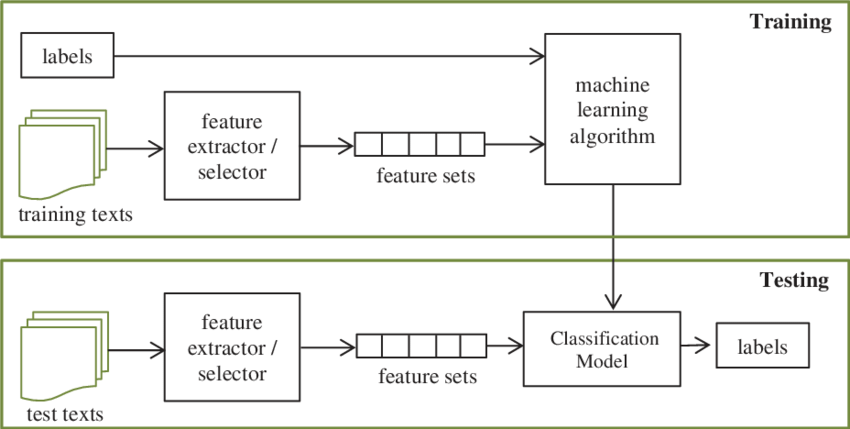

In [ ]:
!python -m spacy download en_core_web_sm
import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
dataset = pd.read_csv("/content/BBC News Train.csv")
test_set = pd.read_csv("/content/BBC News Test.csv")

In [ ]:
test_set.head()

ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...

In [ ]:
dataset.head()

ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

In [ ]:
dataset['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [ ]:
dataset.shape

(1490, 3)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [ ]:
#count values of given categories
dataset['Category'].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [ ]:
#convert categories name into numerical index
# Associate Category names with numerical index and save it in new column CategoryId
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [ ]:
text_category = dataset['Text'].unique()
print(len(text_category))

1440


.factorize():

    This is a method from the Pandas library that encodes categorical values as integers.

In [ ]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   CategoryId  
0           0  
1           0  
2           0  
3           1  
4           0

In [ ]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

Category  CategoryId
0       business           0
3           tech           1
5       politics           2
6          sport           3
7  entertainment           4

In [ ]:
# Create a dictionary ( python datastructure - like a lookup table) that
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category.values)
id_to_category = dict(category[['CategoryId', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [ ]:
#Visulaizing the category data
dataset.groupby('Category').CategoryId.count().plot.bar(ylim = 0)

<Axes: xlabel='Category'>

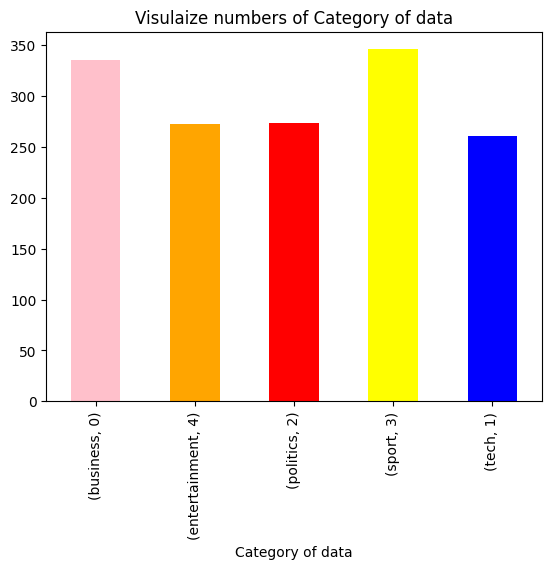

In [ ]:
#visualizing category data in numeric form
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

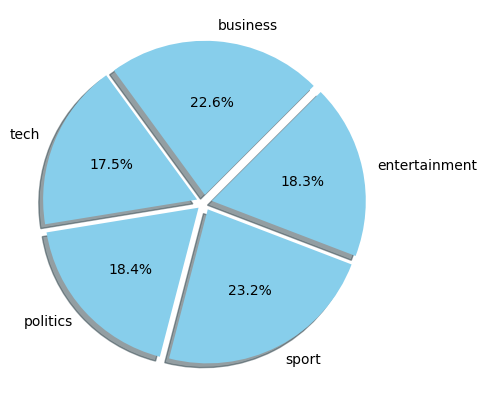

In [ ]:
#visualizing category data in percentage form
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
business = dataset[dataset['CategoryId'] == 0 ]
tech = dataset[dataset['CategoryId'] == 1 ]
politics = dataset[dataset['CategoryId'] == 2]
sport = dataset[dataset['CategoryId'] == 3]
entertainment = dataset[dataset['CategoryId'] == 4]
count = [business['CategoryId'].count(), tech['CategoryId'].count(), politics['CategoryId'].count(), sport['CategoryId'].count(), entertainment['CategoryId'].count()]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05))

business related words:


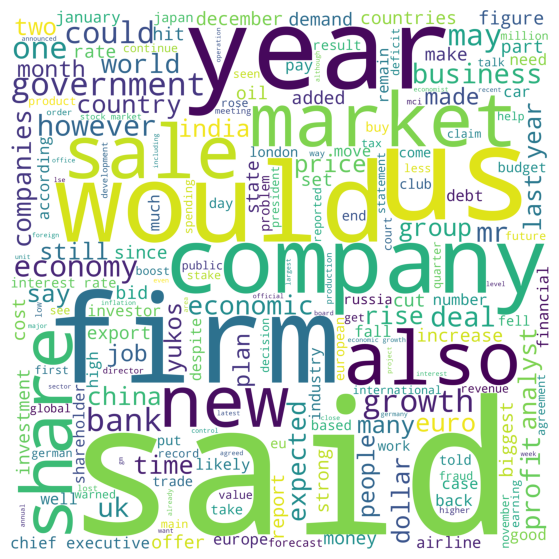

tech related words:


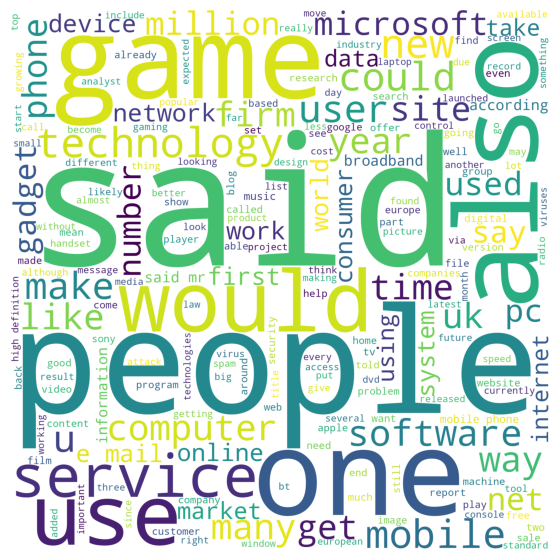

politics related words:


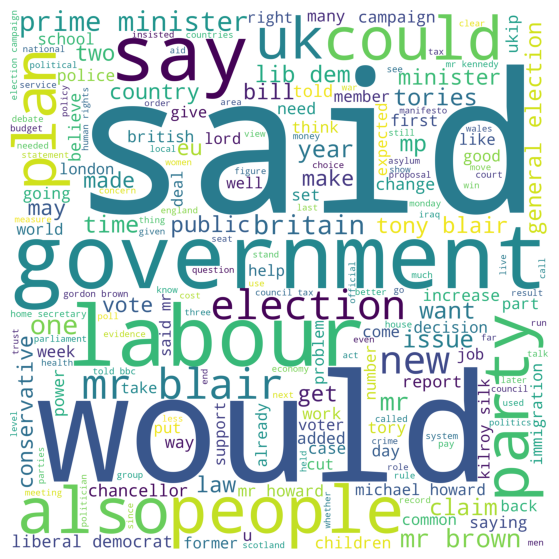

sport related words:


entertainment related words:


In [ ]:
#visualizing category related words
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

business = dataset[dataset['CategoryId'] == 0]
business = business['Text']

tech = dataset[dataset['CategoryId'] == 1]
tech = tech['Text']

politics = dataset[dataset['CategoryId'] == 2]
politics = politics['Text']

sport = dataset[dataset['CategoryId'] == 3]
sport = sport['Text']

entertainment = dataset[dataset['CategoryId'] == 4]
entertainment = entertainment['Text']


def wordcloud_draw(dataset, color = 'white'):
  words = ' '.join(dataset)
  cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

print("business related words:")
wordcloud_draw(business, 'white')

print("tech related words:")
wordcloud_draw(tech, 'white')

print("politics related words:")
wordcloud_draw(politics, 'white')

print("sport related words:")
wordcloud_draw(sport, 'white')

print("entertainment related words:")
wordcloud_draw(entertainment, 'white')

In [ ]:
text = dataset["Text"]
text.head(10)

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
5    howard  truanted to play snooker  conservative...
6    wales silent on grand slam talk rhys williams ...
7    french honour for director parker british film...
8    car giant hit by mercedes slump a slump in pro...
9    fockers fuel festive film chart comedy meet th...
Name: Text, dtype: object

In [ ]:
category = dataset['Category']
category.head(10)

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object

# Duplicating dataset for nlp features and deep learning

In [ ]:
nlp_features_dataset = dataset.copy()

In [ ]:
deep_learning_dataset = dataset

In [ ]:
def remove_tags(text):
  remove = re.compile(r'<.*?>')
  return re.sub(remove, '', text)

dataset['Text'] = dataset['Text'].apply(remove_tags)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

In [ ]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

dataset['Text'] = dataset['Text'].apply(special_char)
dataset['Text'][1]


'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [ ]:
def convert_lower(text):
   return text.lower()

dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [ ]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]

dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]

['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'february',
 'knocking',
 'hopes',
 'speedy',
 'recovery',
 'europe',
 'largest',
 'economy',
 'munich',
 'based',
 'research',
 'institute',
 'ifo',
 'said',
 'confidence',
 'index',
 'fell',
 '95',
 '5',
 'february',
 '97',
 '5',
 'january',
 'first',
 'decline',
 'three',
 'months',
 'study',
 'found',
 'outlook',
 'manufacturing',
 'retail',
 'sectors',
 'worsened',
 'observers',
 'hoping',
 'confident',
 'business',
 'sector',
 'would',
 'signal',
 'economic',
 'activity',
 'picking',
 'surprised',
 'ifo',
 'index',
 'taken',
 'knock',
 'said',
 'dz',
 'bank',
 'economist',
 'bernd',
 'weidensteiner',
 'main',
 'reason',
 'probably',
 'domestic',
 'economy',
 'still',
 'weak',
 'particularly',
 'retail',
 'trade',
 'economy',
 'labour',
 'minister',
 'wolfgang',
 'clement',
 'called',
 'dip',
 'february',
 'ifo',
 'confidence',
 'figure',
 'mild',
 'decline',
 'said',
 'despite',
 'r

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])

dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][1]

'german business confidence slide german business confidence fell february knocking hope speedy recovery europe largest economy munich based research institute ifo said confidence index fell 95 5 february 97 5 january first decline three month study found outlook manufacturing retail sector worsened observer hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew 1 6 last year shrinking 2003 however economy contracted 0 2 last three month 2004 mainly due reluctance consumer spend latest indication growth still proving elusive ifo president han werner sinn said improvement german domestic demand sluggish export

In [ ]:
#preprocessed dataset
dataset

ArticleId                                               Text  \
0          1833  worldcom ex bos launch defence lawyer defendin...   
1           154  german business confidence slide german busine...   
2          1101  bbc poll indicates economic gloom citizen majo...   
3          1976  lifestyle governs mobile choice faster better ...   
4           917  enron boss 168m payout eighteen former enron d...   
...         ...                                                ...   
1485        857  double eviction big brother model caprice holb...   
1486        325  dj double act revamp chart show dj duo jk joel...   
1487       1590  weak dollar hit reuters revenue medium group r...   
1488       1587  apple ipod family expands market apple expande...   
1489        538  santy worm make unwelcome visit thousand websi...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          business  
...             ...  
1485  entertainment  
1486  entertainment  
1487       business  
1488           tech  
1489           tech  

[1490 rows x 3 columns]

In [ ]:
x = dataset['Text']
y = dataset['Category']

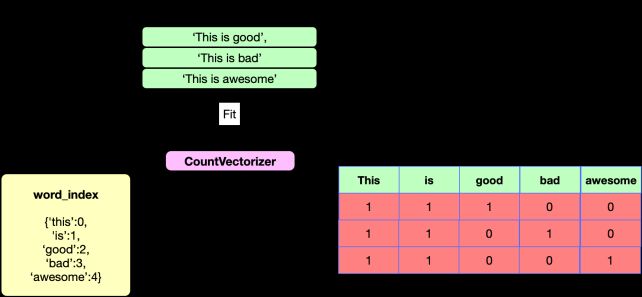

It is a simple and flexible way of extracting features from documents. A Countvectorizer model is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag of words” because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not wherein the document.

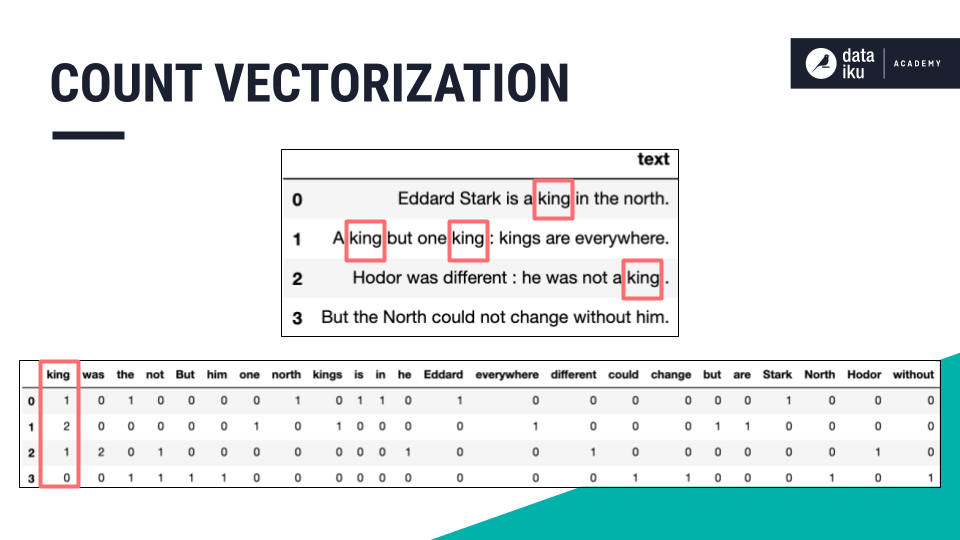

In [ ]:
#create and fit bag of words model

from sklearn.feature_extraction.text import CountVectorizer

x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

cv = CountVectorizer(max_features = 4000)
x = cv.fit_transform(dataset.Text).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 4000)
y.shape =  (1490,)


In [ ]:
x[0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y[0]

0

In [ ]:
# view token vocabulary and counts

print("vocabulary", cv.vocabulary_)

print("shape", x.shape)

print("vectors:", x)

vocabulary {'worldcom': 3960, 'ex': 1338, 'bos': 544, 'launch': 2090, 'defence': 1026, 'lawyer': 2096, 'defending': 1030, 'former': 1524, 'chief': 714, 'ebbers': 1214, 'battery': 447, 'fraud': 1546, 'charge': 696, 'called': 611, 'company': 810, 'first': 1483, 'witness': 3945, 'cooper': 905, 'head': 1730, 'internal': 1929, 'accounting': 156, 'director': 1106, 'practice': 2723, 'telecom': 3596, 'giant': 1618, '2002': 42, 'warning': 3875, 'led': 2112, 'collapse': 774, 'firm': 1482, 'following': 1507, 'discovery': 1117, '11bn': 8, '7bn': 124, 'mr': 2389, 'pleaded': 2676, 'guilty': 1690, 'conspiracy': 864, 'prosecution': 2811, 'argued': 327, 'series': 3223, 'trick': 3712, 'employee': 1262, 'hide': 1758, 'expense': 1360, 'revenue': 3052, 'meet': 2286, 'wall': 3866, 'street': 3460, 'earnings': 1203, 'estimate': 1314, 'run': 3111, 'business': 598, 'told': 3661, 'new': 2438, 'york': 3989, 'wednesday': 3898, 'external': 1382, 'auditor': 388, 'approved': 317, 'early': 1199, '2001': 41, 'said': 31

In [ ]:
#train test and split the dataset into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)


print(len(x_train))
print(len(x_test))

1043
447


In [ ]:
x_train[0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
len(x_train[0])

4000

In [ ]:
x_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_train

array([3, 1, 3, ..., 4, 0, 1])

In [ ]:
y_test

array([4, 2, 3, 2, 3, 0, 0, 1, 4, 0, 3, 4, 2, 1, 3, 1, 0, 4, 0, 4, 1, 1,
       4, 1, 0, 0, 2, 3, 4, 1, 4, 3, 4, 4, 4, 0, 0, 0, 0, 1, 3, 0, 2, 0,
       3, 4, 3, 4, 1, 3, 2, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 1, 3, 0, 3, 1,
       0, 1, 0, 4, 3, 3, 4, 1, 1, 2, 2, 2, 4, 1, 1, 1, 4, 4, 1, 3, 1, 0,
       0, 0, 0, 0, 3, 4, 2, 3, 0, 1, 4, 2, 4, 0, 0, 3, 2, 0, 3, 1, 2, 0,
       4, 4, 2, 2, 4, 4, 4, 4, 1, 2, 2, 0, 2, 3, 4, 1, 3, 3, 3, 3, 3, 3,
       0, 2, 2, 3, 3, 1, 3, 2, 0, 3, 2, 0, 4, 0, 1, 4, 2, 1, 3, 3, 3, 2,
       3, 3, 0, 4, 4, 0, 4, 0, 3, 0, 3, 3, 0, 2, 3, 0, 0, 4, 3, 4, 0, 4,
       1, 2, 0, 4, 1, 1, 1, 2, 1, 3, 0, 0, 4, 3, 2, 4, 2, 1, 0, 2, 2, 3,
       4, 2, 0, 3, 1, 2, 3, 0, 3, 4, 0, 1, 4, 0, 0, 1, 0, 2, 1, 4, 3, 2,
       4, 4, 1, 2, 0, 0, 2, 1, 4, 3, 3, 2, 2, 1, 2, 1, 4, 4, 1, 2, 4, 0,
       3, 3, 3, 1, 0, 2, 4, 2, 0, 1, 1, 0, 2, 3, 2, 2, 0, 4, 0, 1, 3, 1,
       3, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 3, 2, 1, 4, 1, 0, 1, 2, 4, 4, 3,
       3, 0, 0, 4, 1, 4, 3, 3, 1, 4, 4, 2, 1, 1, 4,

In [ ]:
#create list of model and accuracy dicts
perform_list = []

The OneVsRestClassifier is a popular strategy used in machine learning for multi-class classification problems. This method involves training a separate binary classifier for each class. Each classifier is trained to distinguish one class from all the other classes combined.
How It Works:

    Binary Classifiers: For n classes, n binary classifiers are created. Each classifier is responsible for predicting whether an instance belongs to its specific class (positive) or to any of the other classes (negative).

    Training: During the training phase, each classifier is trained on the data labeled with its corresponding class versus all other data.

    Prediction: When making predictions, each classifier outputs a score (or probability) indicating how likely the instance belongs to its class. The class with the highest score across all classifiers is selected as the final prediction.

How OneVsRestClassifier Works

    Creating Classifiers:
        For each category (Sports, Politics, Technology), a separate binary classifier is created.
        Classifier for Sports: This model learns to identify whether an article is about Sports or not.
        Classifier for Politics: This model learns to identify whether an article is about Politics or not.
        Classifier for Technology: This model learns to identify whether an article is about Technology or not.

    Training:
        Each classifier is trained using the articles and their categories.
        For instance, the Sports classifier is trained on the articles labeled with "Sports" as positive examples and those without it as negative examples.

    Making Predictions:
        When a new article is presented, each classifier evaluates it.
        For example, if we have a new article: "The tech company just released an electric car," the classifiers might evaluate as follows:
            Sports Classifier: Low probability (not about sports)
            Politics Classifier: Low probability (not about politics)
            Technology Classifier: High probability (related to technology)

    Final Decision:
        The article is classified based on the highest score from the classifiers. In this case, it would likely be categorized under Technology.

In [ ]:
#create, fit and predict all Machine learning model
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()



    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)


    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [ ]:
y_test[0],y_pred[0]

NameError: name 'y_pred' is not defined

Scenario: News Categorization

Classes:

Business

Tech

Politics

Sport

Entertainment

Binary Transformation:

The problem is transformed into five binary classification tasks, one for each class.

For example, the classifier for "Business" distinguishes business news from all other news categories.

Training:

Each binary classifier is trained independently using the OneVsRestClassifier approach.

The "Business" classifier is trained with positive examples (business news articles) and negative examples (news articles from other categories like Tech, Politics, Sport, and Entertainment).
Prediction:

When a new news article is published, all five classifiers make predictions independently.

For a news article about a recent stock market update:
Business: 1 (is Business)
Tech: 0 (not Tech)
Politics: 0 (not Politics)
Sport: 0 (not Sport)
Entertainment: 0 (not Entertainment)

Output Combination:

The OneVsRestClassifier combines the individual binary predictions into a final output vector: [1, 0, 0, 0, 0].

This means the news article is predicted to belong to the "Business" category and not to any other category.

In [ ]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 97.09
Precision : 0.970917225950783
Recall    : 0.970917225950783
F1-score   : 0.970917225950783


In [ ]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [ ]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [ ]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Support Vector Classifer: % 96.64
Precision : 0.9664429530201343
Recall    : 0.9664429530201343
F1-score   : 0.9664429530201343


In [ ]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Decision Tree Classifier: % 82.33
Precision : 0.8232662192393736
Recall    : 0.8232662192393736
F1-score   : 0.8232662192393736


In [ ]:
#run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

In [ ]:
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Gaussian Naive Bayes: % 77.4
Precision : 0.7740492170022372
Recall    : 0.7740492170022372
F1-score   : 0.7740492170022372


In [ ]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

Model  Test Accuracy  Precision  Recall    F1
0       Logistic Regression          97.09       0.97    0.97  0.97
1             Random Forest          97.54       0.98    0.98  0.98
2   Multinomial Naive Bayes          97.54       0.98    0.98  0.98
3  Support Vector Classifer          96.64       0.97    0.97  0.97
4  Decision Tree Classifier          82.33       0.82    0.82  0.82
5      Gaussian Naive Bayes          77.40       0.77    0.77  0.77

In [ ]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
print("The best accuracy of model is", max_value,"Random Forest")

The best accuracy of model is 97.54 Random Forest


In [ ]:
#Individual train, fit and predict the model

In [ ]:
#regression Model
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
scores = accuracy_score(y_test, y_pred)
print("accuracy of our model is:",scores)
print(classification_report(y_pred, y_test, target_names=target_category))

accuracy of our model is: 0.970917225950783
               precision    recall  f1-score   support

     business       0.98      0.95      0.97       106
         tech       0.95      0.99      0.97        74
     politics       0.91      1.00      0.95        74
        sport       1.00      0.96      0.98       101
entertainment       1.00      0.97      0.98        92

     accuracy                           0.97       447
    macro avg       0.97      0.97      0.97       447
 weighted avg       0.97      0.97      0.97       447



In [ ]:
#Naive Bayes Model
gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0,fit_prior=True),BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(x_train,y_train)
mnb.fit(x_train,y_train)
bnb.fit(x_train,y_train)

ypg = gnb.predict(x_test)
ypm = mnb.predict(x_test)
ypb = bnb.predict(x_test)

print("Gaussian = ",accuracy_score(y_test,ypg))
print("Multinomial = ",accuracy_score(y_test,ypm))
print("Bernoulli = ",accuracy_score(y_test,ypb))

print(classification_report(ypm, y_test, target_names=target_category))

Gaussian =  0.9082774049217002
Multinomial =  0.970917225950783
Bernoulli =  0.9530201342281879
               precision    recall  f1-score   support

     business       0.94      0.99      0.97        98
         tech       0.96      0.96      0.96        77
     politics       0.96      0.95      0.96        82
        sport       1.00      1.00      1.00        97
entertainment       0.99      0.95      0.97        93

     accuracy                           0.97       447
    macro avg       0.97      0.97      0.97       447
 weighted avg       0.97      0.97      0.97       447



In [ ]:
#Support vector Model
svc = SVC()
svc.fit(x_train,y_train)
y_pred1 = svc.predict(x_test)
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_pred1, y_test, target_names=target_category))

0.9552572706935123
               precision    recall  f1-score   support

     business       0.96      0.94      0.95       105
         tech       0.96      0.86      0.91        86
     politics       0.90      1.00      0.95        73
        sport       0.97      0.98      0.97        96
entertainment       0.98      1.00      0.99        87

     accuracy                           0.96       447
    macro avg       0.95      0.96      0.95       447
 weighted avg       0.96      0.96      0.95       447



In [ ]:
#Decision Tree Model
classifier = DecisionTreeClassifier()
classifier.fit(x_train,y_train)
y_pred2 = classifier.predict(x_test)
print(accuracy_score(y_test , y_pred2))
print(classification_report(y_pred2, y_test, target_names=target_category))

0.8411633109619687
               precision    recall  f1-score   support

     business       0.83      0.85      0.84       100
         tech       0.75      0.83      0.79        70
     politics       0.84      0.84      0.84        81
        sport       0.90      0.86      0.88       101
entertainment       0.88      0.82      0.85        95

     accuracy                           0.84       447
    macro avg       0.84      0.84      0.84       447
 weighted avg       0.84      0.84      0.84       447



In [ ]:
#Random Tree Model
forest = RandomForestClassifier(n_estimators=10 ,criterion='entropy' , random_state=0)
forest.fit(x_train,y_train)
y_pred3 = forest.predict(x_test)

print(accuracy_score(y_test , y_pred3))
print(classification_report(y_pred3, y_test, target_names=target_category))

0.8791946308724832
               precision    recall  f1-score   support

     business       0.92      0.79      0.85       120
         tech       0.82      0.93      0.87        68
     politics       0.83      0.89      0.86        75
        sport       0.99      0.88      0.93       109
entertainment       0.81      0.96      0.88        75

     accuracy                           0.88       447
    macro avg       0.87      0.89      0.88       447
 weighted avg       0.89      0.88      0.88       447



In [ ]:
neighbor = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 3)
neighbor.fit(x_train,y_train)
y_pred4 = neighbor.predict(x_test)
print(accuracy_score(y_test , y_pred4))
print(classification_report(y_pred4, y_test, target_names=target_category))

0.7360178970917226
               precision    recall  f1-score   support

     business       0.70      0.86      0.77        84
         tech       0.52      1.00      0.68        40
     politics       0.72      0.98      0.83        59
        sport       1.00      0.50      0.66       195
entertainment       0.70      0.90      0.78        69

     accuracy                           0.74       447
    macro avg       0.73      0.85      0.75       447
 weighted avg       0.82      0.74      0.73       447



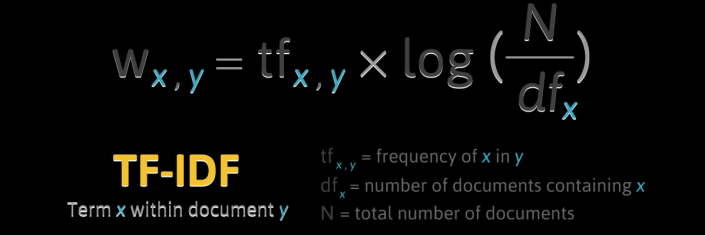

TF-IDF is short for term frequency-inverse document frequency. It’s designed to reflect how important a word is to a document in a collection or corpus.

The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

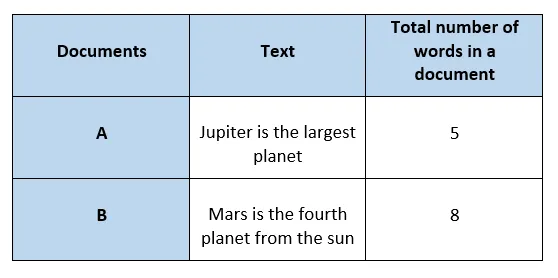

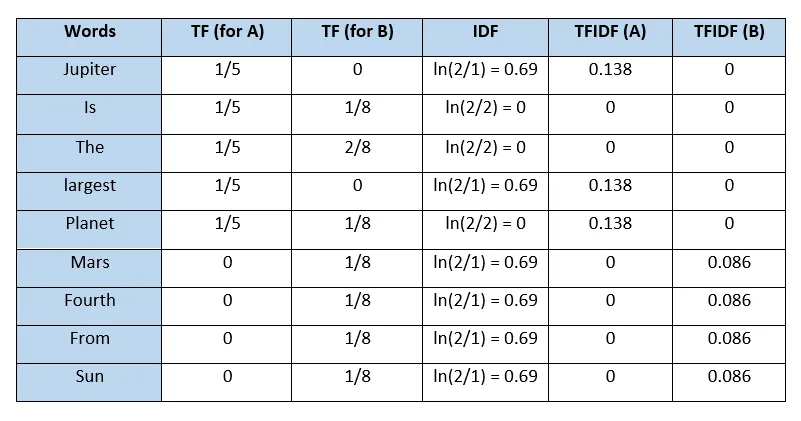

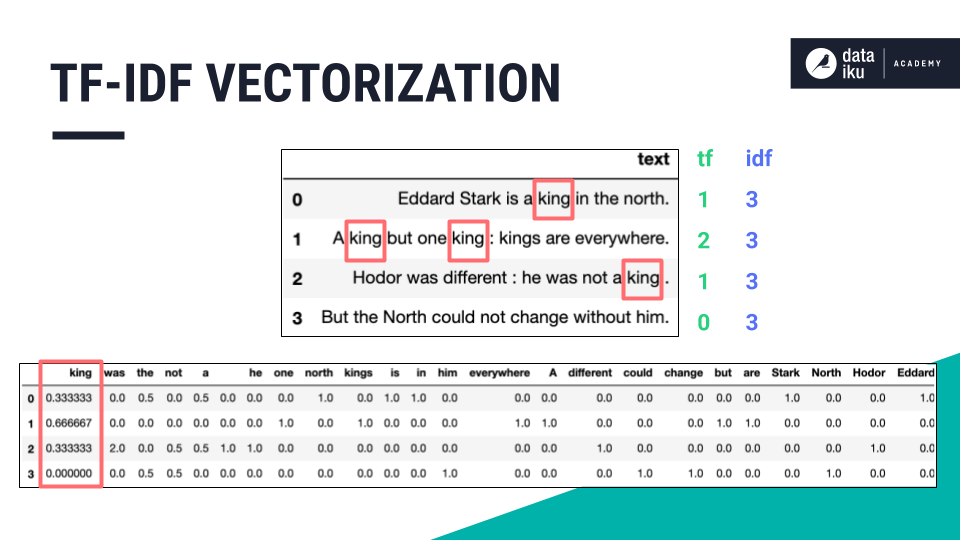

In [ ]:
#tfidf feature

#create and fit bag of words model

from sklearn.feature_extraction.text import TfidfVectorizer

x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

tf = TfidfVectorizer(max_features = 5000)
x = tf.fit_transform(dataset.Text).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [ ]:
# convert sparse matrix to numpy array to view

print("Vocabulary", tf.vocabulary_)

print("idf", tf.idf_)

print("Vectors", x)

Vocabulary {'worldcom': 4954, 'ex': 1667, 'bos': 671, 'launch': 2616, 'defence': 1280, 'lawyer': 2622, 'defending': 1284, 'former': 1897, 'chief': 893, 'ebbers': 1507, 'battery': 540, 'fraud': 1924, 'charge': 869, 'called': 763, 'company': 1004, 'first': 1845, 'witness': 4938, 'cooper': 1128, 'head': 2150, 'internal': 2406, 'accounting': 196, 'director': 1374, 'practice': 3413, 'telecom': 4496, 'giant': 2012, '2002': 59, 'warning': 4853, 'led': 2640, 'collapse': 965, 'firm': 1843, 'following': 1876, 'discovery': 1389, '11bn': 12, '7bn': 152, 'mr': 2992, 'pleaded': 3353, 'guilty': 2094, 'conspiracy': 1070, 'prosecution': 3515, 'argued': 402, 'series': 4018, 'trick': 4646, 'employee': 1571, 'hide': 2187, 'expense': 1700, 'revenue': 3808, 'meet': 2859, 'wall': 4840, 'street': 4320, 'earnings': 1495, 'estimate': 1638, 'run': 3881, 'consulting': 1081, 'business': 743, 'told': 4579, 'jury': 2519, 'new': 3061, 'york': 4986, 'wednesday': 4878, 'external': 1728, 'auditor': 469, 'approved': 389,

In [ ]:
#train test and split the dataset into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)


print(len(x_train))
print(len(x_test))

1043
447


In [ ]:
#create list of model and accuracy dicts
perform_list = []

In [ ]:
#create, fit and predict all Machine learning model
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()



    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)


    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    print(accuracy)
    # Get precision, recall, f1 scores

    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))


In [ ]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

97.99
Test Accuracy Score of Basic Logistic Regression: % 97.99
Precision : 0.9798657718120806
Recall    : 0.9798657718120806
F1-score   : 0.9798657718120806


In [ ]:
run_model('Random Forest', est_c=None, est_pnlty=None)

98.43
Test Accuracy Score of Basic Random Forest: % 98.43
Precision : 0.9843400447427293
Recall    : 0.9843400447427293
F1-score   : 0.9843400447427293


In [ ]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

97.54
Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [ ]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

97.54
Test Accuracy Score of Basic Support Vector Classifer: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [ ]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

77.4
Test Accuracy Score of Basic Decision Tree Classifier: % 77.4
Precision : 0.7740492170022372
Recall    : 0.7740492170022372
F1-score   : 0.7740492170022372


In [ ]:
#run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

86.13
Test Accuracy Score of Basic K Nearest Neighbour: % 86.13
Precision : 0.8612975391498882
Recall    : 0.8612975391498882
F1-score   : 0.8612975391498882


In [ ]:
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

74.27
Test Accuracy Score of Basic Gaussian Naive Bayes: % 74.27
Precision : 0.7427293064876958
Recall    : 0.7427293064876958
F1-score   : 0.7427293064876958


In [ ]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

Model  Test Accuracy  Precision  Recall    F1
0       Logistic Regression          97.99       0.98    0.98  0.98
1             Random Forest          98.43       0.98    0.98  0.98
2   Multinomial Naive Bayes          97.54       0.98    0.98  0.98
3  Support Vector Classifer          97.54       0.98    0.98  0.98
4  Decision Tree Classifier          77.40       0.77    0.77  0.77
5      Gaussian Naive Bayes          74.27       0.74    0.74  0.74

# Classification using NLP features

In [ ]:
#List of features which can be extracted related to text

In [ ]:
nlp_features_dataset

ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  CategoryId  
0          business           0  
1          business           0  
2          business           0  
3              tech           1  
4          business           0  
...             ...         ...  
1485  entertainment           4  
1486  entertainment           4  
1487       business           0  
1488           tech           1  
1489           tech           1  

[1490 rows x 4 columns]

image.png

In [ ]:
# Number of Characters
#Count the number of characters present in a news.
def count_chars(text):
    return len(text)

In [ ]:
#  Number of words

# Count the number of words present in a news.

def count_words(text):
    return len(text.split())

In [ ]:
# count number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

In [ ]:
#  Number of capital words

# Count the number of capital words present in a tweet.

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

In [ ]:
# Count the number of punctuations

# In this function, we return a dictionary of 32 punctuation with the counts, which can be used as separate features, which I will discuss in the next section.

def count_punctuations(text):
    punctuations="!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~"
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d

In [ ]:
# . Number of words in quotes

# The number of words in the single quotation and double quotation.

def count_words_in_quotes(text):
    x = re.findall("\'.\'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

In [ ]:
#  Number of sentences

# Count the number of sentences in a news.

def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [ ]:
# count  average sentence length:
#sum of sentences length divided by the number of sentences (word count/sentence count)

def average_sentence_length(text):
  word_counts = len(text.split())
  sentence_count = len(nltk.sent_tokenize(text))
  return word_counts / sentence_count


In [ ]:
from textblob import TextBlob

In [ ]:
#TextBlob(x).sentiment.polarity

In [ ]:
def sentence_polarity(text):
  if TextBlob(text).sentiment.polarity > 0:
    return 1
  else:
    return 0

In [ ]:
#  Count the number of unique words

# Count the number of unique words in a news.

def count_unique_words(text):
    return len(set(text.split()))

In [ ]:
# Count of hashtags

#  count the number of times news used the hashtag.

def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x)

In [ ]:
# Count of mentions

# counting the number of mentions can also be treated as a feature.

def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

In [ ]:
# Count of stopwords

# Here we will count the number of stopwords used in a news.

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [ ]:
# stopwords vs words
def stopwords_vs_words(stopwords_cnt,text):
    return stopwords_cnt/len(word_tokenize(text))

In [ ]:
#ner spacy example
ner = spacy.load("en_core_web_sm")## tag text
sample_ner_txt = "Will Smith joined Alex to perform for World Cup Song in India"
doc = ner(sample_ner_txt)## display result
spacy.displacy.render(doc,jupyter=True, style="ent")

In [ ]:
nlp_features_dataset

ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  CategoryId  
0          business           0  
1          business           0  
2          business           0  
3              tech           1  
4          business           0  
...             ...         ...  
1485  entertainment           4  
1486  entertainment           4  
1487       business           0  
1488           tech           1  
1489           tech           1  

[1490 rows x 4 columns]

In [ ]:
nlp_features_dataset['char_count'] = nlp_features_dataset["Text"].apply(lambda x:count_chars(x))
nlp_features_dataset['word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_words(x))
nlp_features_dataset['sent_count'] = nlp_features_dataset["Text"].apply(lambda x:count_sent(x))
nlp_features_dataset['capital_char_count'] = nlp_features_dataset["Text"].apply(lambda x:count_capital_chars(x))
nlp_features_dataset['capital_word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_capital_words(x))
nlp_features_dataset['quoted_word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_words_in_quotes(x))
nlp_features_dataset['stopword_count'] = nlp_features_dataset["Text"].apply(lambda x:count_stopwords(x))
nlp_features_dataset['unique_word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_unique_words(x))
nlp_features_dataset['htag_count'] = nlp_features_dataset["Text"].apply(lambda x:count_htags(x))
nlp_features_dataset['mention_count'] = nlp_features_dataset["Text"].apply(lambda x:count_mentions(x))
nlp_features_dataset['punct_count'] = nlp_features_dataset["Text"].apply(lambda x:count_punctuations(x))
nlp_features_dataset['sentiment'] = nlp_features_dataset["Text"].apply(lambda x:sentence_polarity(x))
nlp_features_dataset['avg_wordlength']=nlp_features_dataset['char_count']/nlp_features_dataset['word_count']
nlp_features_dataset['avg_sentlength']=nlp_features_dataset['word_count']/nlp_features_dataset['sent_count']
nlp_features_dataset['unique_vs_words']=nlp_features_dataset['unique_word_count']/nlp_features_dataset['word_count']
nlp_features_dataset['stopwords_vs_words']=nlp_features_dataset['stopword_count']/nlp_features_dataset['word_count']

In [ ]:
nlp_features_dataset

ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  CategoryId  char_count  word_count  sent_count  \
0          business           0        1866         301          12   
1          business           0        2016         325          14   
2          business           0        3104         514          22   
3              tech           1        3618         634          31   
4          business           0        2190         355          16   
...             ...         ...         ...         ...         ...   
1485  entertainment           4        1266         223          11   
1486  entertainment           4        3111         558          28   
1487       business           0        1370         237           8   
1488           tech           1        3242         560          26   
1489           tech           1        1723         295          14   

      capital_char_count  capital_word_count  quoted_word_count  \
0                      0                   0                  0   
1                      0                   0                  0   
2                      0                   0                  0   
3                      0                   0                  0   
4                      0                   0                  0   
...                  ...                 ...                ...   
1485                   0                   0                  0   
1486                   0                   0                  0   
1487                   0                   0                  0   
1488                   0                   0                  0   
1489                   0                   0                  0   

      stopword_count  unique_word_count  htag_count  mention_count  \
0                109                181           0              0   
1                121                199           0              0   
2                221                266           0              0   
3                279                305           0              0   
4                142                223           0              0   
...              ...                ...         ...            ...   
1485              98                132           0              0   
1486             242                305           0              0   
1487              87                146           0              0   
1488             230                285           0              0   
1489             122                170           0              0   

                                            punct_count  sentiment  \
0     {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
1     {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
2     {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
3     {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
4     {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
...                                                 ...        ...   
1485  {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
1486  {'! count': 0, '" count': 0, '# count': 0, '$ ...          1   
1487  {'! count': 0, '" count': 0, '

In [ ]:
nlp_features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ArticleId           1490 non-null   int64  
 1   Text                1490 non-null   object 
 2   Category            1490 non-null   object 
 3   CategoryId          1490 non-null   int64  
 4   char_count          1490 non-null   int64  
 5   word_count          1490 non-null   int64  
 6   sent_count          1490 non-null   int64  
 7   capital_char_count  1490 non-null   int64  
 8   capital_word_count  1490 non-null   int64  
 9   quoted_word_count   1490 non-null   int64  
 10  stopword_count      1490 non-null   int64  
 11  unique_word_count   1490 non-null   int64  
 12  htag_count          1490 non-null   int64  
 13  mention_count       1490 non-null   int64  
 14  punct_count         1490 non-null   object 
 15  sentiment           1490 non-null   int64  
 16  avg_wo

In [ ]:
df_punct= pd.DataFrame(list(nlp_features_dataset.punct_count))

In [ ]:
df_punct

! count  " count  # count  $ count  % count  & count  ' count  ( count  \
0           0        0        0        2        0        0        0        1   
1           0        0        0        0        4        0        0        0   
2           0        0        0        0        6        0        0        1   
3           0        0        0        0        5        0        0        0   
4           0        0        0        7        0        0        0        2   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1485        0        0        0        0        2        0        0        0   
1486        0        0        0        0        0        1        0        0   
1487        0        0        0        1        5        0        0        1   
1488        0        0        0        0        1        0        0        0   
1489        0        0        0        0        0        0        0        0   

      ) count  * count  ...  [ count  \ count  ] count  ^ count  _ count  \
0           1        0  ...        0        0        0        0        0   
1           0        0  ...        0        0        0        0        0   
2           1        0  ...        0        0        0        0        0   
3           0        0  ...        0        0        0        0        0   
4           2        0  ...        0        0        0        0        0   
...       ...      ...  ...      ...      ...      ...      ...      ...   
1485        0        0  ...        0        0        0        0        0   
1486        0        0  ...        0        0        0        0        0   
1487        1        0  ...        0        0        0        0        0   
1488        0        0  ...        0        0        0        0        0   
1489        0        0  ...        0        0        0        0        0   

      ` count  { count  | count  } count  ~ count  
0           0        0        0        0        0  
1           0        0        0        0        0  
2           0        0        0        0        0  
3           0        0        0        0        0  
4           0        0        0        0        0  
...       ...      ...      ...      ...      ...  
1485        0        0        0        0        0  
1486        0        0        0        0        0  
1487        0        0        0        0        0  
1488        0        0        0        0        0  
1489        0        0        0        0        0  

[1490 rows x 32 columns]

In [ ]:
df_punct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ! count  1490 non-null   int64
 1   " count  1490 non-null   int64
 2   # count  1490 non-null   int64
 3   $ count  1490 non-null   int64
 4   % count  1490 non-null   int64
 5   & count  1490 non-null   int64
 6   ' count  1490 non-null   int64
 7   ( count  1490 non-null   int64
 8   ) count  1490 non-null   int64
 9   * count  1490 non-null   int64
 10  + count  1490 non-null   int64
 11  , count  1490 non-null   int64
 12  - count  1490 non-null   int64
 13  . count  1490 non-null   int64
 14  / count  1490 non-null   int64
 15  : count  1490 non-null   int64
 16  ; count  1490 non-null   int64
 17  < count  1490 non-null   int64
 18  = count  1490 non-null   int64
 19  > count  1490 non-null   int64
 20  ? count  1490 non-null   int64
 21  @ count  1490 non-null   int64
 22  [ count  1490 non-null  

In [ ]:
nlp_features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ArticleId           1490 non-null   int64  
 1   Text                1490 non-null   object 
 2   Category            1490 non-null   object 
 3   CategoryId          1490 non-null   int64  
 4   char_count          1490 non-null   int64  
 5   word_count          1490 non-null   int64  
 6   sent_count          1490 non-null   int64  
 7   capital_char_count  1490 non-null   int64  
 8   capital_word_count  1490 non-null   int64  
 9   quoted_word_count   1490 non-null   int64  
 10  stopword_count      1490 non-null   int64  
 11  unique_word_count   1490 non-null   int64  
 12  htag_count          1490 non-null   int64  
 13  mention_count       1490 non-null   int64  
 14  punct_count         1490 non-null   object 
 15  sentiment           1490 non-null   int64  
 16  avg_wo

In [ ]:
# Merging pnctuation DataFrame with main DataFrame
nlp_features_dataset=pd.merge(nlp_features_dataset,df_punct,left_index=True, right_index=True)

In [ ]:
nlp_features_dataset.drop(columns=['punct_count'],inplace=True)

In [ ]:
nlp_features_dataset.columns

Index(['ArticleId', 'Text', 'Category', 'CategoryId', 'char_count',
       'word_count', 'sent_count', 'capital_char_count', 'capital_word_count',
       'quoted_word_count', 'stopword_count', 'unique_word_count',
       'htag_count', 'mention_count', 'sentiment', 'avg_wordlength',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words', '! count',
       '" count', '# count', '$ count', '% count', '& count', '' count',
       '( count', ') count', '* count', '+ count', ', count', '- count',
       '. count', '/ count', ': count', '; count', '< count', '= count',
       '> count', '? count', '@ count', '[ count', '\ count', '] count',
       '^ count', '_ count', '` count', '{ count', '| count', '} count',
       '~ count'],
      dtype='object')

In [ ]:
nlp_features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ArticleId           1490 non-null   int64  
 1   Text                1490 non-null   object 
 2   Category            1490 non-null   object 
 3   CategoryId          1490 non-null   int64  
 4   char_count          1490 non-null   int64  
 5   word_count          1490 non-null   int64  
 6   sent_count          1490 non-null   int64  
 7   capital_char_count  1490 non-null   int64  
 8   capital_word_count  1490 non-null   int64  
 9   quoted_word_count   1490 non-null   int64  
 10  stopword_count      1490 non-null   int64  
 11  unique_word_count   1490 non-null   int64  
 12  htag_count          1490 non-null   int64  
 13  mention_count       1490 non-null   int64  
 14  sentiment           1490 non-null   int64  
 15  avg_wordlength      1490 non-null   float64
 16  avg_se

In [ ]:
nlp_ner_df = pd.DataFrame()
nlp_ner_df["tags"] = nlp_features_dataset["Text"].apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents] )## utils function to count the element of a list
import collections
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict(
                     sorted(dic_counter.items(),
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count
## count tags
nlp_ner_df["tags"] = nlp_ner_df["tags"].apply(lambda x: utils_lst_count(x))
## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0
## extract features
tags_set = []
for lst in nlp_ner_df["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     nlp_ner_df["tags_"+feature] = nlp_ner_df["tags"].apply(lambda x:
                             utils_ner_features(x, feature))


In [ ]:
nlp_ner_df

tags  tags_ORDINAL  \
0     [{('worldcom', 'ORG'): 5}, {('mci', 'ORG'): 2}...             1   
1     [{('german', 'NORP'): 4}, {('february', 'DATE'...             1   
2     [{('bbc', 'ORG'): 4}, {('22', 'CARDINAL'): 2},...             0   
3     [{('dr bjorn', 'PERSON'): 3}, {('2003', 'DATE'...             0   
4     [{('enron', 'ORG'): 2}, {('168', 'MONEY'): 2},...             2   
...                                                 ...           ...   
1485  [{('holby city', 'GPE'): 1}, {('jeremy edwards...             2   
1486  [{('ross', 'PERSON'): 4}, {('40', 'CARDINAL'):...             0   
1487  [{('2004', 'DATE'): 3}, {('11%', 'PERCENT'): 2...             0   
1488  [{('2004', 'DATE'): 2}, {('motorola', 'ORG'): ...             1   
1489  [{('google', 'ORG'): 3}, {('first', 'ORDINAL')...             2   

      tags_LOC  tags_NORP  tags_ORG  tags_QUANTITY  tags_MONEY  tags_FAC  \
0            0          0         8              0           2         0   
1            1          4         3              0           0         0   
2            0          2         6              0           0         0   
3            1          2         1              0           0         0   
4            0          0         6              0          10         0   
...        ...        ...       ...            ...         ...       ...   
1485         0          0         1              0           1         0   
1486         0          0         4              1           0         0   
1487         0          0         3              0          10         0   
1488         1          3         7              0           1         0   
1489         0          0         3              0           0         0   

      tags_TIME  tags_DATE  tags_PRODUCT  tags_LAW  tags_WORK_OF_ART  \
0             0          7             0         0                 0   
1             0          9             0         0                 0   
2             0          6             0         0                 0   
3             0          3             0         0                 0   
4             0          5             0         0                 0   
...         ...        ...           ...       ...               ...   
1485          1          3             0         0                 0   
1486          1          9             0         0                 0   
1487          0         15             0         0                 0   
1488          0          6             0         0                 0   
1489          3          3             0         0                 0   

      tags_EVENT  tags_LANGUAGE  tags_PERCENT  tags_CARDINAL  tags_PERSON  \
0              0              0             0              0            7   
1              0              0             4              2            3   
2              0              0             6             12            2   
3              0              0             5              2            6   
4              0              0             0              3            5   
...          ...            ...           ...            ...          ...   
1485           0              0             2              4            5   
1486           0              0             0             10            7   
1487           0              0             5              1            2   
1488           0              0             1             10            3   
1489           0              0             0              4            0   

      tags_GPE  
0            2  
1            3  
2            9  
3            2  
4            2  
...        ...  
1485         1  
1486         0  
1487         1  
1488         1  
1489         0  

[1490 rows x 19 columns]

In [ ]:
nlp_ner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tags              1490 non-null   object
 1   tags_ORDINAL      1490 non-null   int64 
 2   tags_LOC          1490 non-null   int64 
 3   tags_NORP         1490 non-null   int64 
 4   tags_ORG          1490 non-null   int64 
 5   tags_QUANTITY     1490 non-null   int64 
 6   tags_MONEY        1490 non-null   int64 
 7   tags_FAC          1490 non-null   int64 
 8   tags_TIME         1490 non-null   int64 
 9   tags_DATE         1490 non-null   int64 
 10  tags_PRODUCT      1490 non-null   int64 
 11  tags_LAW          1490 non-null   int64 
 12  tags_WORK_OF_ART  1490 non-null   int64 
 13  tags_EVENT        1490 non-null   int64 
 14  tags_LANGUAGE     1490 non-null   int64 
 15  tags_PERCENT      1490 non-null   int64 
 16  tags_CARDINAL     1490 non-null   int64 
 17  tags_PERSON   

In [ ]:
nlp_ner_df

tags  tags_ORDINAL  \
0     [{('worldcom', 'ORG'): 5}, {('mci', 'ORG'): 2}...             1   
1     [{('german', 'NORP'): 4}, {('february', 'DATE'...             1   
2     [{('bbc', 'ORG'): 4}, {('22', 'CARDINAL'): 2},...             0   
3     [{('dr bjorn', 'PERSON'): 3}, {('2003', 'DATE'...             0   
4     [{('enron', 'ORG'): 2}, {('168', 'MONEY'): 2},...             2   
...                                                 ...           ...   
1485  [{('holby city', 'GPE'): 1}, {('jeremy edwards...             2   
1486  [{('ross', 'PERSON'): 4}, {('40', 'CARDINAL'):...             0   
1487  [{('2004', 'DATE'): 3}, {('11%', 'PERCENT'): 2...             0   
1488  [{('2004', 'DATE'): 2}, {('motorola', 'ORG'): ...             1   
1489  [{('google', 'ORG'): 3}, {('first', 'ORDINAL')...             2   

      tags_LOC  tags_NORP  tags_ORG  tags_QUANTITY  tags_MONEY  tags_FAC  \
0            0          0         8              0           2         0   
1            1          4         3              0           0         0   
2            0          2         6              0           0         0   
3            1          2         1              0           0         0   
4            0          0         6              0          10         0   
...        ...        ...       ...            ...         ...       ...   
1485         0          0         1              0           1         0   
1486         0          0         4              1           0         0   
1487         0          0         3              0          10         0   
1488         1          3         7              0           1         0   
1489         0          0         3              0           0         0   

      tags_TIME  tags_DATE  tags_PRODUCT  tags_LAW  tags_WORK_OF_ART  \
0             0          7             0         0                 0   
1             0          9             0         0                 0   
2             0          6             0         0                 0   
3             0          3             0         0                 0   
4             0          5             0         0                 0   
...         ...        ...           ...       ...               ...   
1485          1          3             0         0                 0   
1486          1          9             0         0                 0   
1487          0         15             0         0                 0   
1488          0          6             0         0                 0   
1489          3          3             0         0                 0   

      tags_EVENT  tags_LANGUAGE  tags_PERCENT  tags_CARDINAL  tags_PERSON  \
0              0              0             0              0            7   
1              0              0             4              2            3   
2              0              0             6             12            2   
3              0              0             5              2            6   
4              0              0             0              3            5   
...          ...            ...           ...            ...          ...   
1485           0              0             2              4            5   
1486           0              0             0             10            7   
1487           0              0             5              1            2   
1488           0              0             1             10            3   
1489           0              0             0              4            0   

      tags_GPE  
0            2  
1            3  
2            9  
3            2  
4            2  
...        ...  
1485         1  
1486         0  
1487         1  
1488         1  
1489         0  

[1490 rows x 19 columns]

In [ ]:
nlp_ner_df.drop(columns=['tags'],inplace=True)

In [ ]:
# General Pre-processing
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('\s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent

In [ ]:
nlp_features_dataset

ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  CategoryId  char_count  word_count  sent_count  \
0          business           0        1866         301          12   
1          business           0        2016         325          14   
2          business           0        3104         514          22   
3              tech           1        3618         634          31   
4          business           0        2190         355          16   
...             ...         ...         ...         ...         ...   
1485  entertainment           4        1266         223          11   
1486  entertainment           4        3111         558          28   
1487       business           0        1370         237           8   
1488           tech           1        3242         560          26   
1489           tech           1        1723         295          14   

      capital_char_count  capital_word_count  quoted_word_count  ...  [ count  \
0                      0                   0                  0  ...        0   
1                      0                   0                  0  ...        0   
2                      0                   0                  0  ...        0   
3                      0                   0                  0  ...        0   
4                      0                   0                  0  ...        0   
...                  ...                 ...                ...  ...      ...   
1485                   0                   0                  0  ...        0   
1486                   0                   0                  0  ...        0   
1487                   0                   0                  0  ...        0   
1488                   0                   0                  0  ...        0   
1489                   0                   0                  0  ...        0   

      \ count  ] count  ^ count  _ count  ` count  { count  | count  } count  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        0        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1485        0        0        0        0        0        0        0        0   
1486        0        0        0        0        0        0        0        0   
1487        0        0        0        0        0        0        0        0   
1488        0        0        0        0        0        0        0        0   
1489        0        0        0        0        0        0        0        0   

      ~ count  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1485        0  
1486        0  
1487        0  
1488        0  
1489        0  

[1490 rows x 51 columns]

In [ ]:
nlp_features_dataset['Text']=nlp_features_dataset['Text'].apply(lambda x: preprocess(x))

In [ ]:
nlp_features_dataset.columns

Index(['ArticleId', 'Text', 'Category', 'CategoryId', 'char_count',
       'word_count', 'sent_count', 'capital_char_count', 'capital_word_count',
       'quoted_word_count', 'stopword_count', 'unique_word_count',
       'htag_count', 'mention_count', 'sentiment', 'avg_wordlength',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words', '! count',
       '" count', '# count', '$ count', '% count', '& count', '' count',
       '( count', ') count', '* count', '+ count', ', count', '- count',
       '. count', '/ count', ': count', '; count', '< count', '= count',
       '> count', '? count', '@ count', '[ count', '\ count', '] count',
       '^ count', '_ count', '` count', '{ count', '| count', '} count',
       '~ count'],
      dtype='object')

In [ ]:
nlp_features_dataset.drop(columns=['ArticleId'],inplace=True)
nlp_features_dataset.drop(columns=['Category'],inplace=True)

In [ ]:
nlp_features_dataset.columns

Index(['ArticleId', 'Text', 'Category', 'CategoryId', 'char_count',
       'word_count', 'sent_count', 'capital_char_count', 'capital_word_count',
       'quoted_word_count', 'stopword_count', 'unique_word_count',
       'htag_count', 'mention_count', 'sentiment', 'avg_wordlength',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words',
       'tags_ORDINAL', 'tags_LOC', 'tags_NORP', 'tags_ORG', 'tags_QUANTITY',
       'tags_MONEY', 'tags_FAC', 'tags_TIME', 'tags_DATE', 'tags_PRODUCT',
       'tags_LAW', 'tags_WORK_OF_ART', 'tags_EVENT', 'tags_LANGUAGE',
       'tags_PERCENT', 'tags_CARDINAL', 'tags_PERSON', 'tags_GPE'],
      dtype='object')

In [ ]:
nlp_features_dataset=pd.merge(nlp_features_dataset,nlp_ner_df,left_index=True, right_index=True)

In [ ]:
nlp_features_dataset.head()

ArticleId                                               Text  Category  \
0       1833  worldcom ex boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  festyle governs mobile choice faster better or...      tech   
4        917  enron bosses in m payout eighteen former enron...  business   

   CategoryId  char_count  word_count  sent_count  capital_char_count  \
0           0        1866         301          12                   0   
1           0        2016         325          14                   0   
2           0        3104         514          22                   0   
3           1        3618         634          31                   0   
4           0        2190         355          16                   0   

   capital_word_count  quoted_word_count  ...  tags_DATE  tags_PRODUCT  \
0                   0                  0  ...          7             0   
1                   0                  0  ...          9             0   
2                   0                  0  ...          6             0   
3                   0                  0  ...          3             0   
4                   0                  0  ...          5             0   

   tags_LAW  tags_WORK_OF_ART  tags_EVENT  tags_LANGUAGE  tags_PERCENT  \
0         0                 0           0              0             0   
1         0                 0           0              0             4   
2         0                 0           0              0             6   
3         0                 0           0              0             5   
4         0                 0           0              0             0   

   tags_CARDINAL  tags_PERSON  tags_GPE  
0              0            7         2  
1              2            3         3  
2             12            2         9  
3              2            6         2  
4              3            5         2  

[5 rows x 69 columns]

In [ ]:
nlp_features_dataset.columns

Index(['Text', 'CategoryId', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'sentiment', 'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count', 'tags_ORDINAL', 'tags_LOC',
       'tags_NORP', 'tags_ORG', 'tags_QUANTITY', 'tags_MONEY', 'tags_FAC',
       'tags_TIME', 'tags_DATE', 'tags_PRODUCT', 'tags_LAW',
       'tags_WORK_OF_ART', 'tags_EVENT', 'tags_LANGUAGE', 'tags_PERCENT',
       'tags_CARDINAL', 'tags_PERSON', 'tags_GPE'],

In [ ]:
# Getting shape of the df
nlp_features_dataset.shape

(1490, 67)

In [ ]:
#dataset['CategoryId'] = dataset['Category'].factorize()[0]

In [ ]:
column_to_move = nlp_features_dataset.pop("CategoryId")

In [ ]:
nlp_features_dataset.insert(34, "label_class", column_to_move )

In [ ]:
nlp_features_dataset

Text  char_count  \
0     worldcom ex boss launches defence lawyers defe...        1866   
1     german business confidence slides german busin...        2016   
2     bbc poll indicates economic gloom citizens in ...        3104   
3     festyle governs mobile choice faster better or...        3618   
4     enron bosses in m payout eighteen former enron...        2190   
...                                                 ...         ...   
1485  double eviction from big brother model caprice...        1266   
1486  dj double act revamp chart show dj duo jk and ...        3111   
1487  weak dollar hits reuters revenues at media gro...        1370   
1488  apple ipod family expands market apple has exp...        3242   
1489  santy worm makes unwelcome visit thousands of ...        1723   

      word_count  sent_count  capital_char_count  capital_word_count  \
0            301          12                   0                   0   
1            325          14                   0                   0   
2            514          22                   0                   0   
3            634          31                   0                   0   
4            355          16                   0                   0   
...          ...         ...                 ...                 ...   
1485         223          11                   0                   0   
1486         558          28                   0                   0   
1487         237           8                   0                   0   
1488         560          26                   0                   0   
1489         295          14                   0                   0   

      quoted_word_count  stopword_count  unique_word_count  htag_count  ...  \
0                     0             109                181           0  ...   
1                     0             121                199           0  ...   
2                     0             221                266           0  ...   
3                     0             279                305           0  ...   
4                     0             142                223           0  ...   
...                 ...             ...                ...         ...  ...   
1485                  0              98                132           0  ...   
1486                  0             242                305           0  ...   
1487                  0              87                146           0  ...   
1488                  0             230                285           0  ...   
1489                  0             122                170           0  ...   

      tags_DATE  tags_PRODUCT  tags_LAW  tags_WORK_OF_ART  tags_EVENT  \
0             7             0         0                 0           0   
1             9             0         0                 0           0   
2             6             0         0                 0           0   
3             3             0         0                 0           0   
4             5             0         0                 0           0   
...         ...           ...       ...               ...         ...   
1485          3             0         0                 0           0   
1486          9             0         0                 0           0   
1487         15             0         0                 0           0   
1488          6             0         0                 0           0   
1489          3             0         0                 0           0   

      tags_LANGUAGE  tags_PERCENT  tags_CARDINAL  tags_PERSON  tags_GPE  
0                 0             0              0            7         2  
1                 0             4              2            3         3  
2                 0             6             12            2         9  
3                 0             5              2            6         2  
4                 0             0              3            5         2  
...             ...           ...            ...          ...  

In [ ]:
nlp_features_dataset.columns

Index(['Text', 'char_count', 'word_count', 'sent_count', 'capital_char_count',
       'capital_word_count', 'quoted_word_count', 'stopword_count',
       'unique_word_count', 'htag_count', 'mention_count', 'sentiment',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', 'tags_ORDINAL', 'tags_LOC', 'tags_NORP',
       'tags_ORG', 'tags_QUANTITY', 'tags_MONEY', 'tags_FAC', 'tags_TIME',
       'tags_DATE', 'tags_PRODUCT', 'tags_LAW', 'tags_WORK_OF_ART',
       'tags_EVENT', 'tags_LANGUAGE', 'tags_PERCENT', 'tags_CARDINAL',
       'tags_PERSON', 'tags_GPE', 'label_class'],
      dtype='object')

In [ ]:
nlp_features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 66 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Text                1490 non-null   object 
 1   char_count          1490 non-null   int64  
 2   word_count          1490 non-null   int64  
 3   sent_count          1490 non-null   int64  
 4   capital_char_count  1490 non-null   int64  
 5   capital_word_count  1490 non-null   int64  
 6   quoted_word_count   1490 non-null   int64  
 7   stopword_count      1490 non-null   int64  
 8   unique_word_count   1490 non-null   int64  
 9   htag_count          1490 non-null   int64  
 10  mention_count       1490 non-null   int64  
 11  sentiment           1490 non-null   int64  
 12  avg_wordlength      1490 non-null   float64
 13  avg_sentlength      1490 non-null   float64
 14  unique_vs_words     1490 non-null   float64
 15  stopwords_vs_words  1490 non-null   float64
 16  ! coun

In [ ]:
nlp_feature_labels = column_to_move

In [ ]:
nlp_feature_labels = nlp_features_dataset['label_class']

In [ ]:
nlp_feature_labels[:]

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: CategoryId, Length: 1490, dtype: int64

In [ ]:
nlp_feature_labels

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: label_class, Length: 1490, dtype: int64

In [ ]:
nlp_features_dataset.drop(columns=['label_class'],inplace=True)

In [ ]:
nlp_features_dataset.columns

Index(['Text', 'char_count', 'word_count', 'sent_count', 'capital_char_count',
       'capital_word_count', 'quoted_word_count', 'stopword_count',
       'unique_word_count', 'htag_count', 'mention_count', 'sentiment',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', 'tags_ORDINAL', 'tags_LOC', 'tags_NORP',
       'tags_ORG', 'tags_QUANTITY', 'tags_MONEY', 'tags_FAC', 'tags_TIME',
       'tags_DATE', 'tags_PRODUCT', 'tags_LAW', 'tags_WORK_OF_ART',
       'tags_EVENT', 'tags_LANGUAGE', 'tags_PERCENT', 'tags_CARDINAL',
       'tags_PERSON', 'tags_GPE'],
      dtype='object')

In [ ]:
nlp_features_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Text                1490 non-null   object 
 1   char_count          1490 non-null   int64  
 2   word_count          1490 non-null   int64  
 3   sent_count          1490 non-null   int64  
 4   capital_char_count  1490 non-null   int64  
 5   capital_word_count  1490 non-null   int64  
 6   quoted_word_count   1490 non-null   int64  
 7   stopword_count      1490 non-null   int64  
 8   unique_word_count   1490 non-null   int64  
 9   htag_count          1490 non-null   int64  
 10  mention_count       1490 non-null   int64  
 11  sentiment           1490 non-null   int64  
 12  avg_wordlength      1490 non-null   float64
 13  avg_sentlength      1490 non-null   float64
 14  unique_vs_words     1490 non-null   float64
 15  stopwords_vs_words  1490 non-null   float64
 16  tags_O

In [ ]:
nlp_features_dataset_copy = nlp_features_dataset.copy()

In [ ]:
final_features = nlp_features_dataset.copy()

In [ ]:
final_features


Text  char_count  \
0     worldcom ex boss launches defence lawyers defe...        1866   
1     german business confidence slides german busin...        2016   
2     bbc poll indicates economic gloom citizens in ...        3104   
3     festyle governs mobile choice faster better or...        3618   
4     enron bosses in m payout eighteen former enron...        2190   
...                                                 ...         ...   
1485  double eviction from big brother model caprice...        1266   
1486  dj double act revamp chart show dj duo jk and ...        3111   
1487  weak dollar hits reuters revenues at media gro...        1370   
1488  apple ipod family expands market apple has exp...        3242   
1489  santy worm makes unwelcome visit thousands of ...        1723   

      word_count  sent_count  capital_char_count  capital_word_count  \
0            301          12                   0                   0   
1            325          14                   0                   0   
2            514          22                   0                   0   
3            634          31                   0                   0   
4            355          16                   0                   0   
...          ...         ...                 ...                 ...   
1485         223          11                   0                   0   
1486         558          28                   0                   0   
1487         237           8                   0                   0   
1488         560          26                   0                   0   
1489         295          14                   0                   0   

      quoted_word_count  stopword_count  unique_word_count  htag_count  ...  \
0                     0             109                181           0  ...   
1                     0             121                199           0  ...   
2                     0             221                266           0  ...   
3                     0             279                305           0  ...   
4                     0             142                223           0  ...   
...                 ...             ...                ...         ...  ...   
1485                  0              98                132           0  ...   
1486                  0             242                305           0  ...   
1487                  0              87                146           0  ...   
1488                  0             230                285           0  ...   
1489                  0             122                170           0  ...   

      tags_DATE  tags_PRODUCT  tags_LAW  tags_WORK_OF_ART  tags_EVENT  \
0             7             0         0                 0           0   
1             9             0         0                 0           0   
2             6             0         0                 0           0   
3             3             0         0                 0           0   
4             5             0         0                 0           0   
...         ...           ...       ...               ...         ...   
1485          3             0         0                 0           0   
1486          9             0         0                 0           0   
1487         15             0         0                 0           0   
1488          6             0         0                 0           0   
1489          3             0         0                 0           0   

      tags_LANGUAGE  tags_PERCENT  tags_CARDINAL  tags_PERSON  tags_GPE  
0                 0             0              0            7         2  
1                 0             4              2            3         3  
2                 0             6             12            2         9  
3                 0             5              2            6         2  
4                 0             0              3            5         2  
...             ...           ...            ...          ...  

In [ ]:
nlp_features_dataset_copy

Text  char_count  \
0     worldcom ex boss launches defence lawyers defe...        1866   
1     german business confidence slides german busin...        2016   
2     bbc poll indicates economic gloom citizens in ...        3104   
3     festyle governs mobile choice faster better or...        3618   
4     enron bosses in m payout eighteen former enron...        2190   
...                                                 ...         ...   
1485  double eviction from big brother model caprice...        1266   
1486  dj double act revamp chart show dj duo jk and ...        3111   
1487  weak dollar hits reuters revenues at media gro...        1370   
1488  apple ipod family expands market apple has exp...        3242   
1489  santy worm makes unwelcome visit thousands of ...        1723   

      word_count  sent_count  capital_char_count  capital_word_count  \
0            301          12                   0                   0   
1            325          14                   0                   0   
2            514          22                   0                   0   
3            634          31                   0                   0   
4            355          16                   0                   0   
...          ...         ...                 ...                 ...   
1485         223          11                   0                   0   
1486         558          28                   0                   0   
1487         237           8                   0                   0   
1488         560          26                   0                   0   
1489         295          14                   0                   0   

      quoted_word_count  stopword_count  unique_word_count  htag_count  ...  \
0                     0             109                181           0  ...   
1                     0             121                199           0  ...   
2                     0             221                266           0  ...   
3                     0             279                305           0  ...   
4                     0             142                223           0  ...   
...                 ...             ...                ...         ...  ...   
1485                  0              98                132           0  ...   
1486                  0             242                305           0  ...   
1487                  0              87                146           0  ...   
1488                  0             230                285           0  ...   
1489                  0             122                170           0  ...   

      tags_DATE  tags_PRODUCT  tags_LAW  tags_WORK_OF_ART  tags_EVENT  \
0             7             0         0                 0           0   
1             9             0         0                 0           0   
2             6             0         0                 0           0   
3             3             0         0                 0           0   
4             5             0         0                 0           0   
...         ...           ...       ...               ...         ...   
1485          3             0         0                 0           0   
1486          9             0         0                 0           0   
1487         15             0         0                 0           0   
1488          6             0         0                 0           0   
1489          3             0         0                 0           0   

      tags_LANGUAGE  tags_PERCENT  tags_CARDINAL  tags_PERSON  tags_GPE  
0                 0             0              0            7         2  
1                 0             4              2            3         3  
2                 0             6             12            2         9  
3                 0             5              2            6         2  
4                 0             0              3            5         2  
...             ...           ...            ...          ...  

In [ ]:
tfn_vectorizer =  TfidfVectorizer()
nlp_features_dataset_copy_tf_idf_features =  tfn_vectorizer.fit_transform(nlp_features_dataset_copy['Text']).toarray()
nlp_features_dataset_copy_tf_idf_features_df  = pd.DataFrame(nlp_features_dataset_copy_tf_idf_features)


In [ ]:
nlp_features_dataset_copy_tf_idf_features_df

0      1      2      3      4      5      6      7      8      9      \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1485    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1486    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1487    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1488    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1489    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      ...  23596  23597  23598  23599  23600  23601  23602  23603  23604  \
0     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1485  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1486  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1487  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1488  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1489  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      23605  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
1485    0.0  
1486    0.0  
1487    0.0  
1488    0.0  
1489    0.0  

[1490 rows x 23606 columns]

In [ ]:
nlp_features_dataset_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 66 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Text                1490 non-null   object 
 1   char_count          1490 non-null   int64  
 2   word_count          1490 non-null   int64  
 3   sent_count          1490 non-null   int64  
 4   capital_char_count  1490 non-null   int64  
 5   capital_word_count  1490 non-null   int64  
 6   quoted_word_count   1490 non-null   int64  
 7   stopword_count      1490 non-null   int64  
 8   unique_word_count   1490 non-null   int64  
 9   htag_count          1490 non-null   int64  
 10  mention_count       1490 non-null   int64  
 11  sentiment           1490 non-null   int64  
 12  avg_wordlength      1490 non-null   float64
 13  avg_sentlength      1490 non-null   float64
 14  unique_vs_words     1490 non-null   float64
 15  stopwords_vs_words  1490 non-null   float64
 16  ! coun

In [ ]:
final_features.drop(columns=['Text'],inplace=True)

In [ ]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 65 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   char_count          1490 non-null   int64  
 1   word_count          1490 non-null   int64  
 2   sent_count          1490 non-null   int64  
 3   capital_char_count  1490 non-null   int64  
 4   capital_word_count  1490 non-null   int64  
 5   quoted_word_count   1490 non-null   int64  
 6   stopword_count      1490 non-null   int64  
 7   unique_word_count   1490 non-null   int64  
 8   htag_count          1490 non-null   int64  
 9   mention_count       1490 non-null   int64  
 10  sentiment           1490 non-null   int64  
 11  avg_wordlength      1490 non-null   float64
 12  avg_sentlength      1490 non-null   float64
 13  unique_vs_words     1490 non-null   float64
 14  stopwords_vs_words  1490 non-null   float64
 15  ! count             1490 non-null   int64  
 16  " coun

In [ ]:
nlp_features_dataset_copy.drop(columns=['Text'],inplace=True)

In [ ]:
nlp_features_dataset_copy

char_count  word_count  sent_count  capital_char_count  \
0           1866         301          12                   0   
1           2016         325          14                   0   
2           3104         514          22                   0   
3           3618         634          31                   0   
4           2190         355          16                   0   
...          ...         ...         ...                 ...   
1485        1266         223          11                   0   
1486        3111         558          28                   0   
1487        1370         237           8                   0   
1488        3242         560          26                   0   
1489        1723         295          14                   0   

      capital_word_count  quoted_word_count  stopword_count  \
0                      0                  0             109   
1                      0                  0             121   
2                      0                  0             221   
3                      0                  0             279   
4                      0                  0             142   
...                  ...                ...             ...   
1485                   0                  0              98   
1486                   0                  0             242   
1487                   0                  0              87   
1488                   0                  0             230   
1489                   0                  0             122   

      unique_word_count  htag_count  mention_count  ...  tags_DATE  \
0                   181           0              0  ...          7   
1                   199           0              0  ...          9   
2                   266           0              0  ...          6   
3                   305           0              0  ...          3   
4                   223           0              0  ...          5   
...                 ...         ...            ...  ...        ...   
1485                132           0              0  ...          3   
1486                305           0              0  ...          9   
1487                146           0              0  ...         15   
1488                285           0              0  ...          6   
1489                170           0              0  ...          3   

      tags_PRODUCT  tags_LAW  tags_WORK_OF_ART  tags_EVENT  tags_LANGUAGE  \
0                0         0                 0           0              0   
1                0         0                 0           0              0   
2                0         0                 0           0              0   
3                0         0                 0           0              0   
4                0         0                 0           0              0   
...            ...       ...               ...         ...            ...   
1485             0         0                 0           0              0   
1486             0         0                 0           0              0   
1487             0         0                 0           0              0   
1488             0         0                 0           0              0   
1489             0         0                 0           0              0   

      tags_PERCENT  tags_CARDINAL  tags_PERSON  tags_GPE  
0                0              0            7         2  
1                4              2            3         3  
2                6             12            2         9  
3                5              2            6         2  
4                0              3            5         2  
...            ...            ...          ...       ...  
1485             2              4            5         1  
1486             0             10            7         0  
1487             5              1            2         1  
1488             1             10            3         1  
1489             0              4            0         0  

[1490

In [ ]:
nlp_features_final = pd.merge(final_features,nlp_features_dataset_copy_tf_idf_features_df,left_index=True, right_index=True)

In [ ]:
nlp_features_final

char_count  word_count  sent_count  capital_char_count  \
0           1866         301          12                   0   
1           2016         325          14                   0   
2           3104         514          22                   0   
3           3618         634          31                   0   
4           2190         355          16                   0   
...          ...         ...         ...                 ...   
1485        1266         223          11                   0   
1486        3111         558          28                   0   
1487        1370         237           8                   0   
1488        3242         560          26                   0   
1489        1723         295          14                   0   

      capital_word_count  quoted_word_count  stopword_count  \
0                      0                  0             109   
1                      0                  0             121   
2                      0                  0             221   
3                      0                  0             279   
4                      0                  0             142   
...                  ...                ...             ...   
1485                   0                  0              98   
1486                   0                  0             242   
1487                   0                  0              87   
1488                   0                  0             230   
1489                   0                  0             122   

      unique_word_count  htag_count  mention_count  ...  23596  23597  23598  \
0                   181           0              0  ...    0.0    0.0    0.0   
1                   199           0              0  ...    0.0    0.0    0.0   
2                   266           0              0  ...    0.0    0.0    0.0   
3                   305           0              0  ...    0.0    0.0    0.0   
4                   223           0              0  ...    0.0    0.0    0.0   
...                 ...         ...            ...  ...    ...    ...    ...   
1485                132           0              0  ...    0.0    0.0    0.0   
1486                305           0              0  ...    0.0    0.0    0.0   
1487                146           0              0  ...    0.0    0.0    0.0   
1488                285           0              0  ...    0.0    0.0    0.0   
1489                170           0              0  ...    0.0    0.0    0.0   

      23599  23600  23601  23602  23603  23604  23605  
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
...     ...    ...    ...    ...    ...    ...    ...  
1485    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1486    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1487    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1488    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1489    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[1490 rows x 23671 columns]

In [ ]:
nlp_features_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Columns: 23671 entries, char_count to 23605
dtypes: float64(23610), int64(61)
memory usage: 269.1 MB


In [ ]:
nlp_features_dataset_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 65 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   char_count          1490 non-null   int64  
 1   word_count          1490 non-null   int64  
 2   sent_count          1490 non-null   int64  
 3   capital_char_count  1490 non-null   int64  
 4   capital_word_count  1490 non-null   int64  
 5   quoted_word_count   1490 non-null   int64  
 6   stopword_count      1490 non-null   int64  
 7   unique_word_count   1490 non-null   int64  
 8   htag_count          1490 non-null   int64  
 9   mention_count       1490 non-null   int64  
 10  sentiment           1490 non-null   int64  
 11  avg_wordlength      1490 non-null   float64
 12  avg_sentlength      1490 non-null   float64
 13  unique_vs_words     1490 non-null   float64
 14  stopwords_vs_words  1490 non-null   float64
 15  ! count             1490 non-null   int64  
 16  " coun

In [ ]:
nlp_features_final.columns = nlp_features_final.columns.astype(str)

In [ ]:
nlp_features_final

char_count  word_count  sent_count  capital_char_count  \
0           1866         301          12                   0   
1           2016         325          14                   0   
2           3104         514          22                   0   
3           3618         634          31                   0   
4           2190         355          16                   0   
...          ...         ...         ...                 ...   
1485        1266         223          11                   0   
1486        3111         558          28                   0   
1487        1370         237           8                   0   
1488        3242         560          26                   0   
1489        1723         295          14                   0   

      capital_word_count  quoted_word_count  stopword_count  \
0                      0                  0             109   
1                      0                  0             121   
2                      0                  0             221   
3                      0                  0             279   
4                      0                  0             142   
...                  ...                ...             ...   
1485                   0                  0              98   
1486                   0                  0             242   
1487                   0                  0              87   
1488                   0                  0             230   
1489                   0                  0             122   

      unique_word_count  htag_count  mention_count  ...  23596  23597  23598  \
0                   181           0              0  ...    0.0    0.0    0.0   
1                   199           0              0  ...    0.0    0.0    0.0   
2                   266           0              0  ...    0.0    0.0    0.0   
3                   305           0              0  ...    0.0    0.0    0.0   
4                   223           0              0  ...    0.0    0.0    0.0   
...                 ...         ...            ...  ...    ...    ...    ...   
1485                132           0              0  ...    0.0    0.0    0.0   
1486                305           0              0  ...    0.0    0.0    0.0   
1487                146           0              0  ...    0.0    0.0    0.0   
1488                285           0              0  ...    0.0    0.0    0.0   
1489                170           0              0  ...    0.0    0.0    0.0   

      23599  23600  23601  23602  23603  23604  23605  
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
...     ...    ...    ...    ...    ...    ...    ...  
1485    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1486    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1487    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1488    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1489    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[1490 rows x 23671 columns]

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:
train_nlp, val_nlp, train_label, val_label = train_test_split(nlp_features_final,nlp_feature_labels, test_size = 0.3, random_state = 0, shuffle = True)


In [ ]:
val_label

9       4
354     2
1227    3
907     2
575     3
       ..
1030    3
892     0
1434    3
431     1
194     3
Name: CategoryId, Length: 447, dtype: int64

In [ ]:
#x = np.array(dataset.iloc[:,0].values)
train_label_ = train_label.to_numpy()
val_label_ = val_label.to_numpy()

#Prediction with NLP features

In [ ]:
perform_list_nlp = []

In [ ]:
#create, fit and predict all Machine learning model
def run_model_nlp(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()



    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(train_nlp, train_label_)
    y_pred = oneVsRest.predict(val_nlp)


    # Performance metrics
    accuracy = round(accuracy_score(val_label_, y_pred) * 100, 2)
    #print(accuracy)
    # Get precision, recall, f1 scores

    precision, recall, f1score, support = score(val_label_, y_pred, average='micro')

    #print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    #print(f'Precision : {precision}')
    #print(f'Recall    : {recall}')
    #print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list_nlp.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))


In [ ]:
run_model_nlp('Logistic Regression', est_c=None, est_pnlty=None)

run_model_nlp('Random Forest', est_c=None, est_pnlty=None)

run_model_nlp('Multinomial Naive Bayes', est_c=None, est_pnlty=None)


run_model_nlp('Support Vector Classifer', est_c=None, est_pnlty=None)

run_model_nlp('Decision Tree Classifier', est_c=None, est_pnlty=None)

#run_model_nlp('K Nearest Neighbour', est_c=None, est_pnlty=None)

run_model_nlp('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

model_performance_nlp = pd.DataFrame(data=perform_list_nlp)
model_performance_nlp = model_performance_nlp[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
model_performance_nlp

Model  Test Accuracy  Precision  Recall    F1
0       Logistic Regression          66.89       0.67    0.67  0.67
1             Random Forest          96.20       0.96    0.96  0.96
2   Multinomial Naive Bayes          60.85       0.61    0.61  0.61
3  Support Vector Classifer          50.34       0.50    0.50  0.50
4  Decision Tree Classifier          81.88       0.82    0.82  0.82
5      Gaussian Naive Bayes          79.19       0.79    0.79  0.79

In [ ]:
#individual classifier
model = SVC()
model.fit(train_nlp, train_label_)
y_pred = model.predict(val_nlp)
scores = accuracy_score(val_label_, y_pred)
print("accuracy of our model is:",scores)
print(classification_report(y_pred, y_test, target_names=target_category))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


accuracy of our model is: 0.3512304250559284
               precision    recall  f1-score   support

     business       0.62      0.34      0.44       187
         tech       0.22      0.50      0.31        34
     politics       0.42      0.27      0.33       125
        sport       0.43      0.42      0.42       101
entertainment       0.00      0.00      0.00         0

     accuracy                           0.35       447
    macro avg       0.34      0.31      0.30       447
 weighted avg       0.49      0.35      0.40       447



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Deep learning for multiclass text classification

In [ ]:
!pip install chart_studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
import sys
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objs import *
import plotly.figure_factory as ff
import chart_studio
import chart_studio.plotly as py

# to avoid warnings
import warnings
warnings.filterwarnings("ignore")

# text processing
import nltk
from nltk.tokenize import word_tokenize

# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Scikit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE


In [ ]:
dl_train, dl_test = train_test_split(deep_learning_dataset, test_size=0.3)

In [ ]:
dl_train

ArticleId                                               Text  \
1237       1273  vera drake s bafta triumph hope at the bafta f...   
328         726  vw considers opening indian plant volkswagen i...   
1275        484  mixed reaction to man utd offer shares in manc...   
31         1407  rapper snoop dogg sued for  rape  us rapper sn...   
1459       2206  dance music not dead says fatboy dj norman coo...   
...         ...                                                ...   
912         655  asylum children to face returns the uk governm...   
964         629  volcano drama erupts on bbc one supervolcano  ...   
1478       1144  visa row mandarin made sir john the top civil ...   
280          65  india power shares jump on debut shares in ind...   
866        1903  labour trio  had vote-rig factory  three labou...   

           Category  CategoryId  
1237  entertainment           4  
328        business           0  
1275       business           0  
31    entertainment           4  
1459  entertainment           4  
...             ...         ...  
912        politics           2  
964   entertainment           4  
1478       politics           2  
280        business           0  
866        politics           2  

[1043 rows x 4 columns]

In [ ]:
dl_test

ArticleId                                               Text  \
311         453  ask jeeves tips online ad revival ask jeeves h...   
88          699  britain boosted by holmes double athletics fan...   
229        1128  my memories of marley...  to mark the 60th ann...   
481         441  lasers help bridge network gaps an indian tele...   
1171       2019  uk plan to deport terror suspects deals are be...   
...         ...                                                ...   
546        1967  kuznetsova  failed a drugs test  us open champ...   
1270       1495  brit awards for devon music acts devon singer ...   
580        1926  warning over us pensions deficit taxpayers may...   
518        1607  edu describes tunnel fracas arsenal s edu has ...   
11         1153  housewives lift channel 4 ratings the debut of...   

           Category  CategoryId  
311        business           0  
88            sport           3  
229   entertainment           4  
481            tech           1  
1171       politics           2  
...             ...         ...  
546           sport           3  
1270  entertainment           4  
580        business           0  
518           sport           3  
11    entertainment           4  

[447 rows x 4 columns]

In [ ]:
#Convert the label to one-hot encoded form and organize text column as training feature and the one-hot encoded label as training labels.

dl_train_features, dl_train_labels = dl_train['Text'], tf.one_hot(
    dl_train["CategoryId"], 5)
dl_test_features, dl_test_labels = dl_test['Text'], tf.one_hot(
    dl_test["CategoryId"], 5)

In [ ]:
dl_train_labels

<tf.Tensor: shape=(1043, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

In [ ]:
dl_train_features

1237    vera drake s bafta triumph hope at the bafta f...
328     vw considers opening indian plant volkswagen i...
1275    mixed reaction to man utd offer shares in manc...
31      rapper snoop dogg sued for  rape  us rapper sn...
1459    dance music not dead says fatboy dj norman coo...
                              ...                        
912     asylum children to face returns the uk governm...
964     volcano drama erupts on bbc one supervolcano  ...
1478    visa row mandarin made sir john the top civil ...
280     india power shares jump on debut shares in ind...
866     labour trio  had vote-rig factory  three labou...
Name: Text, Length: 1043, dtype: object

Set Parameters



vocab_size = 15000
max_seq_len = 100
vector_size = 300

Example:

    vocab_size = 15000: This means we will keep track of up to 15,000 unique words from our dataset.
    max_seq_len = 100: Any piece of text longer than 100 words will be cut off, and shorter texts will be padded to make them 100 words long.
    vector_size = 300: This is for when we eventually create word embeddings, but it’s not directly used in this part of the code.


Prepare the Tokenizer



tokenizer = Tokenizer(oov_token = "<OOV>", num_words=vocab_size)

Example:

    The Tokenizer is initialized with a special token <OOV> that will be used to represent any word not in our vocabulary of 15,000 words.
    If the text contains a word like "unicorn," and it’s not in the top 15,000 most frequent words, it will be replaced with <OOV>.


Fit the Tokenizer



tokenizer.fit_on_texts(dl_train['Text'])

Example:

    Suppose your training data contains the following sentences:
        "I love programming."
        "Programming is fun."
        "I love coding."
    After fitting the tokenizer, it might create a word index like this:

{
    "I": 1,
    "love": 2,
    "programming": 3,
    "is": 4,
    "fun": 5,
    "coding": 6
}

Here, each word has been assigned a unique integer based on its frequency.


Convert Text to Sequences


sequences_train = tokenizer.texts_to_sequences(dl_train['Text'])

sequences_test = tokenizer.texts_to_sequences(dl_test['Text'])

Example:

    For the training sentences "I love programming" and "Programming is fun," the conversion to sequences would look like this:
        "I love programming." → [1, 2, 3]
        "Programming is fun." → [3, 4, 5]
    
    Note that "Programming" in the second sentence would map to the same integer as "programming" in the first sentence if case sensitivity is handled, otherwise, it may lead to different integers if the tokenizer is case-sensitive.


Pad Sequences


padded_train = pad_sequences(sequences_train, padding='post', maxlen=max_seq_len)

padded_test = pad_sequences(sequences_test, padding='post', maxlen=max_seq_len)

Example:

    If our sequences are:
        [1, 2, 3] (length 3)
        [3, 4, 5] (length 3)
    After padding to a maximum length of 100, they would become:
        [1, 2, 3, 0, 0, ..., 0] (97 zeros added)
        [3, 4, 5, 0, 0, ..., 0] (97 zeros added)

The final padded sequences will have a uniform shape of (100,) for each input, making them ready for model training or evaluation.

In [ ]:
vocab_size = 1000
max_seq_len = 120
vector_size = 16

tokenizer = Tokenizer(oov_token = "<OOV>", num_words=vocab_size)
tokenizer.fit_on_texts(dl_train['Text'])

sequences_train = tokenizer.texts_to_sequences(dl_train['Text'])
sequences_test = tokenizer.texts_to_sequences(dl_test['Text'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_seq_len)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_seq_len)

In [ ]:
dl_test['Text']

311     ask jeeves tips online ad revival ask jeeves h...
88      britain boosted by holmes double athletics fan...
229     my memories of marley...  to mark the 60th ann...
481     lasers help bridge network gaps an indian tele...
1171    uk plan to deport terror suspects deals are be...
                              ...                        
546     kuznetsova  failed a drugs test  us open champ...
1270    brit awards for devon music acts devon singer ...
580     warning over us pensions deficit taxpayers may...
518     edu describes tunnel fracas arsenal s edu has ...
11      housewives lift channel 4 ratings the debut of...
Name: Text, Length: 447, dtype: object

In [ ]:
print(dl_test['Text'][481])
sequences_train_inp = tokenizer.texts_to_sequences([dl_test['Text'][481]])
print(sequences_train_inp[0])

lasers help bridge network gaps an indian telecommunications firm has turned to lasers to help it overcome the problems of setting up voice and data networks in the country.  tata teleservices is using the lasers to make the link between customers  offices and its own core network. the laser bridges work across distances up to 4km and can be set up much faster than cable connections. in 12 months the lasers have helped the firm set up networks in more than 700 locations.   in this particular geography getting permission to dig the ground and lay the pipes is a bit of a task   said mr r. sridharan  vice president of networks at tata.  heavy traffic and the layout under the ground mean that digging is uniquely difficult   he said. in some locations  he said  permission to dig up roads and lay cables was impossible to get. he said it was far easier to secure permission for putting networking hardware on roofs. this has led chennai-based tata to turn to equipment that uses lasers to make t

In [ ]:
tokenizer.oov_token

'<OOV>'

What is LSTM?

    Basic Idea: LSTMs are a type of neural network designed to work with sequences of data, like time series or text. Unlike traditional neural networks, LSTMs can remember information for a long time, which is really useful when the order of data matters (like in sentences).

    Memory Cells: At the core of an LSTM is a memory cell that can store information. This cell can decide what information to keep, what to forget, and what new information to add. This ability helps LSTMs capture context over longer sequences.

    Gates: LSTMs use three gates:
        Input Gate: Controls what new information gets added to the cell.
        Forget Gate: Decides what information to discard from the cell.
        Output Gate: Determines what information from the cell gets passed to the next layer.

How LSTMs are Used for Text Classification

    Input Representation: Text is first converted into a numerical format, often using techniques like word embeddings (e.g., Word2Vec or GloVe). This turns words into vectors that the LSTM can process.

    Sequence Processing: When you feed a sentence into an LSTM, it processes one word (or token) at a time, updating its memory cell based on the current word and what it has learned from the previous words. This helps it understand the context of the sentence.

    Final Output: After processing all the words in a sentence, the LSTM generates an output that summarizes the information. This output can be used to determine the classification of the text (e.g., sentiment analysis, topic classification).

    Classification Layer: Finally, the output is fed into a classification layer (like a softmax layer) that predicts the label for the text based on the learned representations. For instance, it might classify a review as positive or negative.

Designing the LSTM Model


    Input Layer: Accepts the padded sequences of numbers.

    Embedding Layer: This layer converts the integer representations of words into dense vectors (i.e., numerical arrays) that capture semantic meaning. This is crucial for understanding the context.

    LSTM Layer: The heart of the model, which processes the sequences. It remembers important information from previous words while also learning to forget irrelevant data. This helps the model understand context over the length of the sentence.

    Dense Layer: After the LSTM processes the input, the output is fed into a dense layer that helps to summarize the information learned.

    Output Layer: This final layer uses a softmax or sigmoid activation function to predict the sentiment label (positive or negative).

1. Input Layer

    Purpose: Accepts the padded sequences of integers.
    Example: Suppose we have two sentences:
        Sentence 1: "I love this product!" (Padded: [1, 2, 3, 4, 0])
        Sentence 2: "This is terrible." (Padded: [5, 6, 7, 0, 0])

The input layer will accept these sequences as input data for processing.
2. Embedding Layer

    Purpose: Converts integer representations into dense vectors.
    Example: Each unique word is represented as a vector of numbers that captures its meaning. For instance:
        "I" → [0.1, 0.2, 0.3]
        "love" → [0.5, 0.1, 0.4]
        "this" → [0.3, 0.3, 0.5]
        "product" → [0.4, 0.4, 0.2]
        "terrible" → [0.6, 0.1, 0.7]

When a sentence is passed through the embedding layer, it transforms the input integer sequences into a matrix of vectors representing the meanings of the words.
3. LSTM Layer

    Purpose: Processes the sequences and maintains contextual information.
    Example: As the LSTM reads the embedded vectors for "I love this product!", it updates its memory based on:
        "I" → remembers the sentiment is likely positive.
        "love" → strengthens the positive sentiment.
        "this" → provides context for the product.
        "product" → concludes the context and reinforces the positive sentiment.

The LSTM will retain this information and can remember or forget based on what it deems relevant, leading to an understanding of the overall sentiment.
4. Dense Layer

    Purpose: Summarizes the information learned by the LSTM.
    Example: After processing through the LSTM, the model outputs a vector summarizing the sentiment. The dense layer takes this vector and combines it into a more concise representation that can inform the final classification.

Suppose the output vector from the LSTM for a positive sentence might look like this:

    LSTM Output → [0.7, 0.2, 0.1]

The dense layer processes this output, potentially applying weights and biases, resulting in a new vector that’s ready for classification.

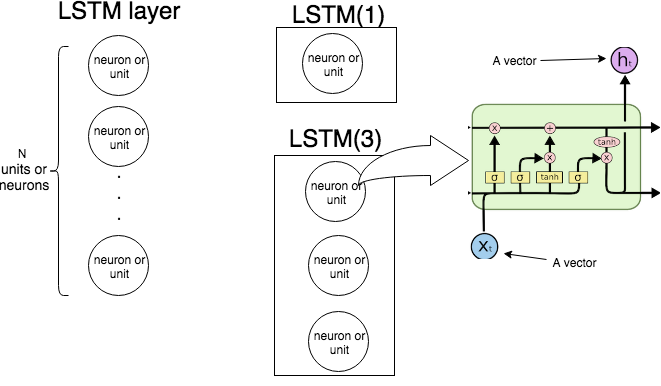

In [ ]:
def get_dl_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size,
                  input_length=max_seq_len))
    model.add(Dropout(0.6))
    model.add(LSTM(32,return_sequences=True)) # LSTM layer with 128 units
    model.add(LSTM(16))  # LSTM layer summarizing to 5 units
    model.add(Dropout(0.2))
    model.add(Dense(5,activation='softmax'))
    return model

In [ ]:
def get_dl_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size,
                  input_length=max_seq_len))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))  # Increased units
    model.add(Dropout(0.2))
    model.add(LSTM(32))  # Increased units
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    return model


In [ ]:
from keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional

In [ ]:
def get_dl_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size,
                  input_length=max_seq_len))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM with 64 units
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))  # Bidirectional LSTM with 32 units
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))  # Output layer
    return model

Sequential Model:

    model = Sequential(): This initializes a sequential model, which allows you to stack layers linearly.

Embedding Layer:

    model.add(Embedding(input_dim=vocab_size, output_dim=vector_size, input_length=max_seq_len)):
        This layer converts integer-encoded words (from your vocabulary) into dense vectors of fixed size (vector_size).
        input_dim=vocab_size: The size of the vocabulary (total unique words).
        output_dim=vector_size: The dimension of the output vectors (how many features each word will be represented by).
        input_length=max_seq_len: The length of the input sequences; all input sequences will be padded/truncated to this length.

Example:

    input_dim=10000: There are 10,000 unique words in the dataset.
    output_dim=8: Each word will be represented as an 8-dimensional vector.
    input_length=10: Each input sequence (news article) will be truncated or padded to 10 words.

If we have the article:


"Breaking news: The government has announced new policies."

Assuming it’s tokenized (words converted to their respective integer indices based on the vocabulary), we might have:


[1234, 5678, 9101, 1112, 1314, 1516, 1718, 1920, 2021, 2223]

The embedding layer converts these integers into dense vectors of size 8. For example:

    "Breaking" might map to [0.1, -0.2, 0.3, 0.4, -0.1, 0.0, 0.5, -0.3]
    "news:" might map to [0.0, 0.1, -0.4, 0.2, 0.3, 0.1, -0.2, 0.0]
    And so on for each word.

So, the output of the embedding layer for the entire article (10 words) would be a 3D tensor of shape (batch_size, 10, 8).




Dropout Layer:

    model.add(Dropout(0.6)):
        This layer is used to prevent overfitting by randomly setting a fraction (60% in this case) of the input units to zero during training.
        It helps in regularization, making the model more robust.

  Example: This layer randomly deactivates 60% of the neurons in the previous layer's output during training. Suppose the embedding output for our article is:

```
[
  [0.1, -0.2, 0.3, 0.4, -0.1, 0.0, 0.5, -0.3],
  [0.0, 0.1, -0.4, 0.2, 0.3, 0.1, -0.2, 0.0],
  ...
]
```
After applying dropout, some of these values will be set to zero. For example:


```
[
  [0.0, -0.2, 0.0, 0.4, -0.1, 0.0, 0.0, -0.3],
  [0.0, 0.1, -0.0, 0.0, 0.3, 0.1, -0.2, 0.0],
  ...
]
```
This helps the model generalize better.

LSTM Layers:

    model.add(LSTM(max_seq_len, return_sequences=True)):
        This is the first LSTM layer.
        It has max_seq_len units, and since return_sequences=True, it will return the full sequence of outputs for each input sequence, which is useful for stacking multiple LSTM layers.
    model.add(LSTM(5)):
        This is the second LSTM layer with 5 units.
        It does not return sequences (the default behavior), so it will return only the last output of the sequence, which is typical before the output layer.

Dense Layer:

    model.add(Dense(5, activation='softmax')):
        This is a fully connected layer that produces the final output.
        It has 5 units, which likely corresponds to 5 classes for a classification task.
        The softmax activation function converts the outputs into probabilities that sum to 1, which is ideal for multi-class classifica

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=2,
                                  verbose=1,
                                  mode="min",
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_no_w2v.keras',
                                    verbose=1,
                                    save_best_only=True)
]

monitor: This parameter specifies the quantity to monitor during training. Here, it is set to "val_loss", which means the callback will keep track of the validation loss during training.

patience: This parameter determines how many epochs with no improvement to wait before stopping the training. In this case, if the validation loss does not improve for 2 consecutive epochs, training will stop.

verbose: This controls the verbosity of the output. Setting it to 1 means that the callback will print messages when it stops training.

mode: This specifies whether the monitored quantity should be minimized or maximized. Here, it is set to "min", indicating that the callback should look for a minimum in the validation loss.

restore_best_weights: When this is set to True, the model will revert to the weights from the epoch that had the best performance (i.e., the lowest validation loss). This helps ensure that the final model is the best one observed during training.

In [ ]:
dl_model = get_dl_model()
dl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           16000     
                                                                 
 dropout_6 (Dropout)         (None, 120, 16)           0         
                                                                 
 bidirectional (Bidirection  (None, 120, 128)          41472     
 al)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 120, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 64)               

optimizer='adam': This specifies the optimizer to use for updating the model's weights during training. Adam (Adaptive Moment Estimation) is a popular optimizer that combines the benefits of two other extensions of stochastic gradient descent, and it is well-suited for a variety of problems.

loss='categorical_crossentropy': This defines the loss function to use during training. Categorical crossentropy is typically used for multi-class classification problems, where the output is one of several classes. It measures the dissimilarity between the true labels and the predicted probabilities.

metrics=['accuracy']: This specifies the metric(s) to track during training and evaluation. In this case, accuracy is being tracked, which will give the proportion of correctly predicted instances out of the total instances.

In [ ]:
dl_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
dl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           16000     
                                                                 
 dropout_6 (Dropout)         (None, 120, 16)           0         
                                                                 
 bidirectional (Bidirection  (None, 120, 128)          41472     
 al)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 120, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 64)               

Layer Breakdown

    Embedding Layer:
        Type: Embedding
        Output Shape: (32, 100, 300)
            This means you have a batch size of 32, a sequence length of 100, and each word is represented by a 300-dimensional vector.
        Parameters: 4,500,000
            This is calculated as vocab_size * embedding_dim, where vocab_size is 15,000 (the number of unique tokens/words) and embedding_dim is 300 (the size of the embedding vector).

    Dropout Layer:
        Type: Dropout
        Output Shape: (32, 100, 300)
            The output shape remains the same as the input shape because dropout only modifies the values during training to prevent overfitting.
        Parameters: 0
            Dropout layers don't have any trainable parameters; they simply drop a proportion of the inputs during training.

    First LSTM Layer:
        Type: LSTM
        Output Shape: (32, 100, 128)
            This indicates that for each of the 32 sequences, the LSTM produces an output sequence of 100 timesteps, each with a feature size of 128.
        Parameters: 219,648
            The number of parameters for an LSTM layer can be calculated using the formula:
            params=4×(units×(input_dim+units+1))
            params=4×(units×(input_dim+units+1))
            Here, units is 128, and input_dim is 300 (the dimensionality of the input from the embedding layer).

    Second LSTM Layer:
        Type: LSTM
        Output Shape: (32, 5)
            The second LSTM is set to return only the final output for each batch (which corresponds to a sequence of length 5). Hence, the output shape reflects the batch size and the number of classes (5).
        Parameters: 2,680
            This is calculated similarly as above, with units set to 5 (the number of classes).

    Dense Layer:
        Type: Dense
        Output Shape: (32, 5)
            This layer outputs a vector of size 5 for each of the 32 samples in the batch, corresponding to the logits for each class.
        Parameters: 30
            This is calculated as input_dim * output_dim + output_dim, where input_dim is 5 (from the previous LSTM) and output_dim is also 5 (the number of classes).

Total Parameters

    Total Params: 4,722,358
        This is the sum of all parameters across all layers. All parameters are trainable, meaning the model will adjust these weights during training.

In [ ]:

tf.config.run_functions_eagerly(True)
history = dl_model.fit(padded_train,
                           dl_train_labels,
                           validation_split=0.33,
                           callbacks=callbacks,
                           epochs=10)

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 1.6057 - accuracy: 0.2178
Epoch 1: val_loss did not improve from 0.80824
22/22 [==============================] - 37s 2s/step - loss: 1.6057 - accuracy: 0.2178 - val_loss: 1.5982 - val_accuracy: 0.2870
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 1.5975 - accuracy: 0.2307
Epoch 2: val_loss did not improve from 0.80824
22/22 [==============================] - 37s 2s/step - loss: 1.5975 - accuracy: 0.2307 - val_loss: 1.5945 - val_accuracy: 0.3797
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 1.4837 - accuracy: 0.3567
Epoch 3: val_loss did not improve from 0.80824
22/22 [==============================] - 37s 2s/step - loss: 1.4837 - accuracy: 0.3567 - val_loss: 1.2337 - val_accuracy: 0.3971
Epoch 4/10
22/22 [==============================] - ETA: 0s - loss: 1.2460 - accuracy: 0.4398
Epoch 4: val_loss did not improve from 0.80824
22/22 [==============================] - 37s 2s/s

In [ ]:
history = dl_model.fit(
    padded_train,
    dl_train_labels,
    validation_split=0.33,
    callbacks=callbacks,
    epochs=20,  # Total epochs to run (initial + additional)
    initial_epoch=10  # Start from epoch 10
)

Epoch 11/20
22/22 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.7636
Epoch 11: val_loss improved from 0.77077 to 0.69011, saving model to models/lstm_with_no_w2v.keras
22/22 [==============================] - 37s 2s/step - loss: 0.5971 - accuracy: 0.7636 - val_loss: 0.6901 - val_accuracy: 0.7478
Epoch 12/20
22/22 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8653
Epoch 12: val_loss did not improve from 0.69011
22/22 [==============================] - 37s 2s/step - loss: 0.4247 - accuracy: 0.8653 - val_loss: 0.6992 - val_accuracy: 0.7420
Epoch 13/20
22/22 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8940
Epoch 13: val_loss improved from 0.69011 to 0.63705, saving model to models/lstm_with_no_w2v.keras
22/22 [==============================] - 37s 2s/step - loss: 0.3877 - accuracy: 0.8940 - val_loss: 0.6371 - val_accuracy: 0.7768
Epoch 14/20
22/22 [==============================] - ETA: 0s - loss: 0.3228 - accu

In [ ]:
# Evaluate the model
loss, accuracy = dl_model.evaluate(padded_test, dl_test_labels)
print(f'Test accuracy: {accuracy:.4f}')

14/14 [==============================] - 9s 641ms/step - loss: 0.6798 - accuracy: 0.7673
Test accuracy: 0.7673


In [ ]:
dl_test

ArticleId                                               Text  \
311         453  ask jeeves tips online ad revival ask jeeves h...   
88          699  britain boosted by holmes double athletics fan...   
229        1128  my memories of marley...  to mark the 60th ann...   
481         441  lasers help bridge network gaps an indian tele...   
1171       2019  uk plan to deport terror suspects deals are be...   
...         ...                                                ...   
546        1967  kuznetsova  failed a drugs test  us open champ...   
1270       1495  brit awards for devon music acts devon singer ...   
580        1926  warning over us pensions deficit taxpayers may...   
518        1607  edu describes tunnel fracas arsenal s edu has ...   
11         1153  housewives lift channel 4 ratings the debut of...   

           Category  CategoryId  
311        business           0  
88            sport           3  
229   entertainment           4  
481            tech           1  
1171       politics           2  
...             ...         ...  
546           sport           3  
1270  entertainment           4  
580        business           0  
518           sport           3  
11    entertainment           4  

[447 rows x 4 columns]

In [ ]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_len)
    prediction = dl_model.predict(padded)

    # Convert probabilities to one-hot encoding
    one_hot_prediction = np.zeros((1, 5))  # Assuming 5 categories
    one_hot_prediction[0, prediction.argmax()] = 1

    return one_hot_prediction

    #return label_encoder.inverse_transform([prediction.argmax()])


sample = dl_test['Text'][1270]
print(sample)
# Example prediction
print(predict_text(sample))


brit awards for devon music acts devon singer joss stone and rock band muse won coveted brit awards during the event s 25th anniversary.  seventeen-year-old stone  from near cullumpton  won two awards: best british female act  and best urban act out of three award nominations. muse  whose members met in south devon  beat franz ferdinand  jamie cullum  kasabian and the libertines for best british live act. the band has sold about two million records worldwide.  after beating amy winehouse  jamelia  natasha bedingfield and pj harvey to the best british female prize  joss stone said:  i don t know what to say. i don t like doing this at all. i d like to thank my family for being really supportive and everybody that made my record with me.   i don t even know what to do right now. thank you all you guys for voting for me  i feel sick right now.  viewers of digital music tv channel mtv base voted stone the winner in the best urban act category. ms stone also performed her song right to be w

In [ ]:
#Training - Validation Loss
metric_to_plot = "loss"
epochs = list(range(1, max(history.epoch) + 2))
training_loss = history.history[metric_to_plot]
validation_loss = history.history["val_" + metric_to_plot]

trace1 = {
    "mode": "lines+markers",
    "name": "Training Loss",
    "type": "scatter",
    "x": epochs,
    "y": training_loss
}

trace2 = {
    "mode": "lines+markers",
    "name": "Validation Loss",
    "type": "scatter",
    "x": epochs,
    "y": validation_loss
}

data = Data([trace1, trace2])
layout = {
    "title": "Training - Validation Loss",
    "xaxis": {
        "title": "Number of epochs",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    },
    "yaxis": {
        "title": "Loss",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    }
}
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
fig.show()

In [ ]:
#Training - Validation Accuracy
metric_to_plot = "accuracy"
epochs = list(range(1, max(history.epoch) + 2))
training_loss = history.history[metric_to_plot]
validation_loss = history.history["val_" + metric_to_plot]

trace1 = {
    "mode": "lines+markers",
    "name": "Training Accuracy",
    "type": "scatter",
    "x": epochs,
    "y": training_loss
}

trace2 = {
    "mode": "lines+markers",
    "name": "Validation Accuracy",
    "type": "scatter",
    "x": epochs,
    "y": validation_loss
}

data = Data([trace1, trace2])
layout = {
    "title": "Training - Validation Accuracy",
    "xaxis": {
        "title": "Number of epochs",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    },
    "yaxis": {
        "title": "Accuracy",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    }
}
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
fig.show()

Expected

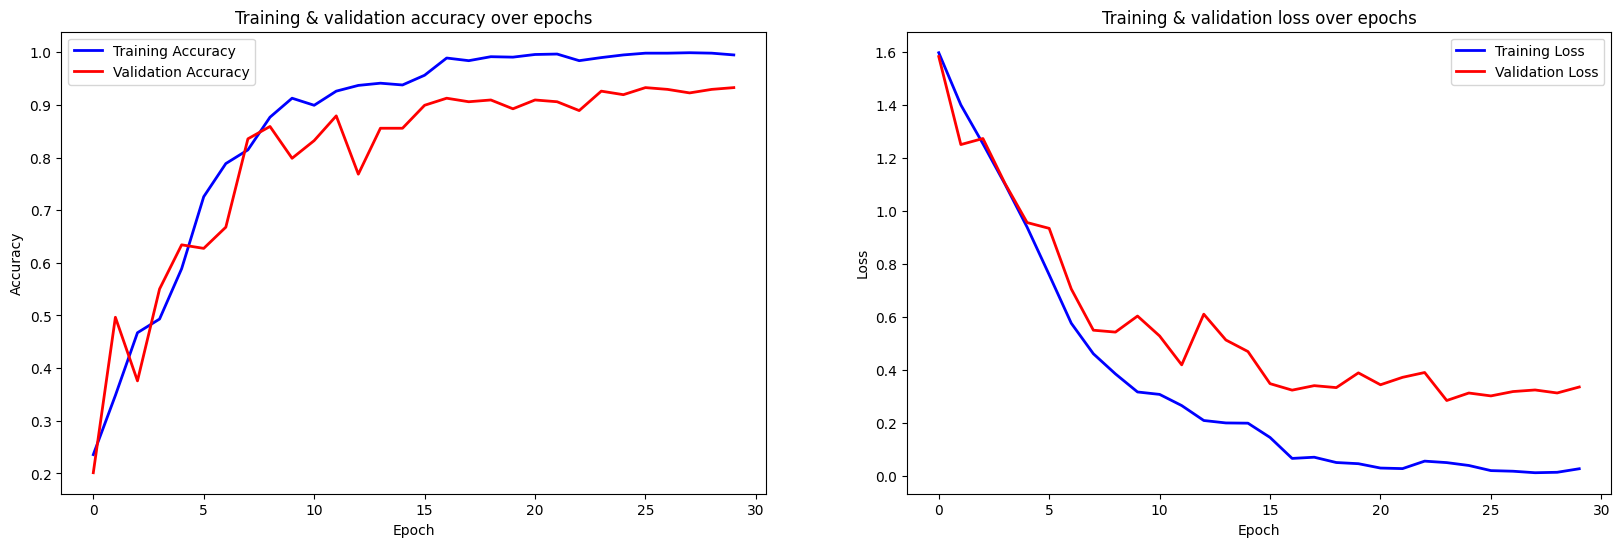

# **Language Model for Text Classification**

A language model is a type of machine learning model trained to conduct a probability distribution over words. Put it simply, a model tries to predict the next most appropriate word to fill in a blank space in a sentence or phrase, based on the context of the given text.

Essentially, a language model predicts the likelihood of a sequence of words, helping it to understand context, grammar, and meaning.

For example, in a sentence that sounds like this, “Jenny dropped by the office for the keys so I gave them to [...],” a good model will determine that the missed word is likely to be a pronoun. Since the relevant piece of information here is Jenny, the most probable pronoun is she or her.

For example, if you start a sentence with "The cat sat on the," a language model can predict that "mat" is a likely next word based on its training.

The important thing is that the model doesn’t focus on grammar, but rather on how words are used in a way that is similar to how people write.

![0ca2bb9f-1dac-4652-b0eb-cad8d289c11b.webp]()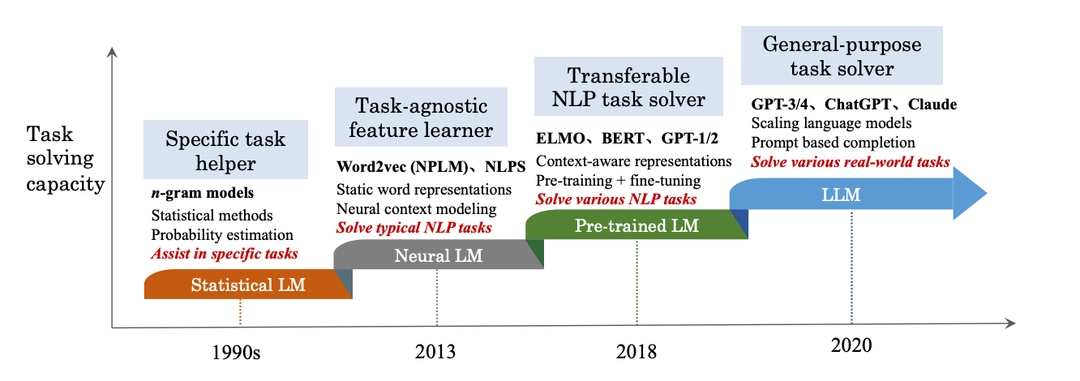

klu-large-language-models-timeline.webp

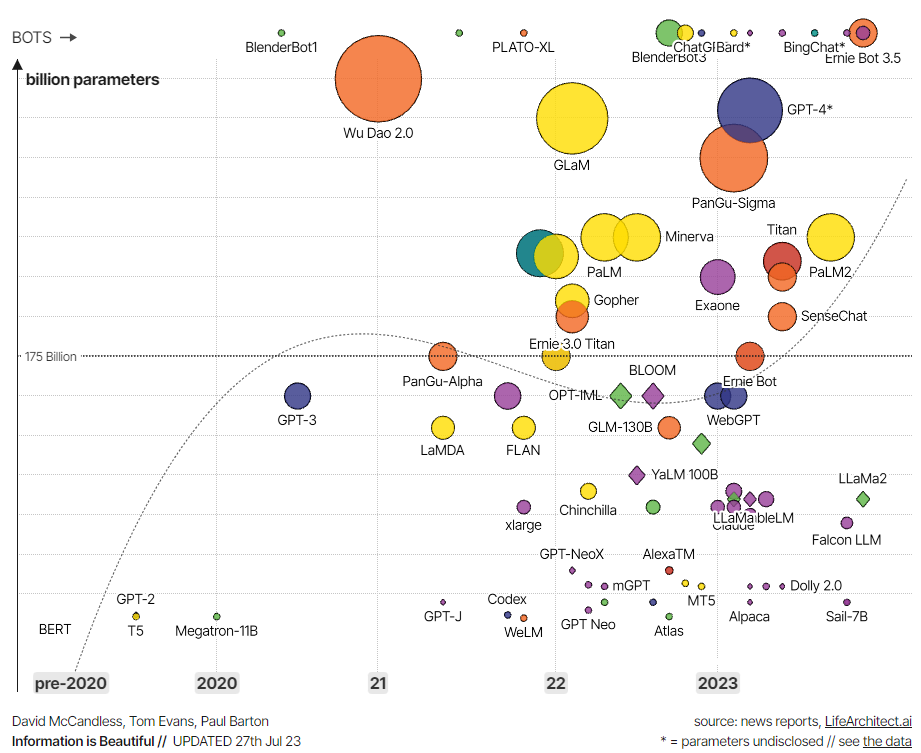

BERT (Bidirectional Encoder Representations from Transformers) is a type of neural network architecture designed for understanding the context of words in a sentence. It uses a mechanism called "transformers" to process words in relation to all the other words in a sentence at the same time, rather than one at a time. This bidirectional approach means it looks at the words both before and after a target word to grasp its meaning fully. BERT is pre-trained on a large amount of text, allowing it to understand language nuances and perform well on various natural language processing tasks, like answering questions or sentiment analysis.

BERT (Bidirectional Encoder Representations from Transformers) is a powerful model for understanding language. Imagine you have the sentence, "The bank can refuse to lend money." The word "bank" can refer to a financial institution or the side of a river.

BERT processes this sentence by looking at all the words around "bank" at the same time. It sees "refuse" and "lend," which suggest that "bank" is likely referring to a financial institution. This bidirectional context helps BERT understand that "bank" in this case means a place where you get loans, not a riverbank.

Because BERT is pre-trained on a massive dataset, it learns these kinds of relationships and meanings, making it effective for tasks like answering questions or translating text. For example, if you asked, "What does the bank do?" BERT can infer you're asking about a financial institution, thanks to its understanding of context.

**Pre-training Process Explained**

    Goal:
        The main goal of pre-training is to help the model understand language by learning from a large amount of text data.

    Data Collection:
        The model is trained on a vast dataset, often made up of books, articles, and websites. This helps the model learn grammar, facts, and general knowledge about the world.

    Masked Language Modeling:
        BERT uses a technique called masked language modeling. During training, some words in a sentence are randomly replaced with a special token (like "[MASK]"). The model learns to predict these masked words based on the context provided by the surrounding words.
        Example: For the sentence "The cat sat on the [MASK]," the model should learn to predict "mat."

    Next Sentence Prediction:
        BERT also learns to predict whether one sentence follows another. This helps the model understand relationships between sentences.
        Example: Given "The cat sat on the mat." and "It was a sunny day," the model learns to identify if the second sentence makes sense after the first.

    Output:
        After pre-training, the model has a strong understanding of language, which can be fine-tuned for specific tasks like sentiment analysis, translation, or question answering.

**Fine-tuning** is a process in machine learning where a pre-trained model is adapted to a specific task or dataset. After a model, like BERT, has been trained on a large amount of general data, fine-tuning involves making slight adjustments to its parameters using a smaller, task-specific dataset.

For example, if you want to use BERT for sentiment analysis, you would take the pre-trained BERT model and further train it on a dataset containing examples of positive and negative sentiments. This helps the model learn the specific nuances and requirements of the new task, improving its performance without starting from scratch. Fine-tuning allows for quicker and more efficient training while leveraging the general knowledge the model already has.

Imagine a student who plays soccer and has general skills in passing, dribbling, and shooting (the pre-trained model). Now, the student wants to improve specifically for their role as a goalkeeper.

Instead of practicing all the soccer skills, they focus only on goalkeeper drills: catching, diving, and positioning. They might watch videos of professional goalkeepers, practice saving shots, and work on their reflexes. This specialized training helps them become a better goalkeeper without needing to relearn everything about soccer.

In the same way, fine-tuning a language model involves taking a model that has broad language knowledge and training it specifically on a narrower task, like translating medical texts or writing poetry, enhancing its performance in that specific area!

Fine-tuining language model

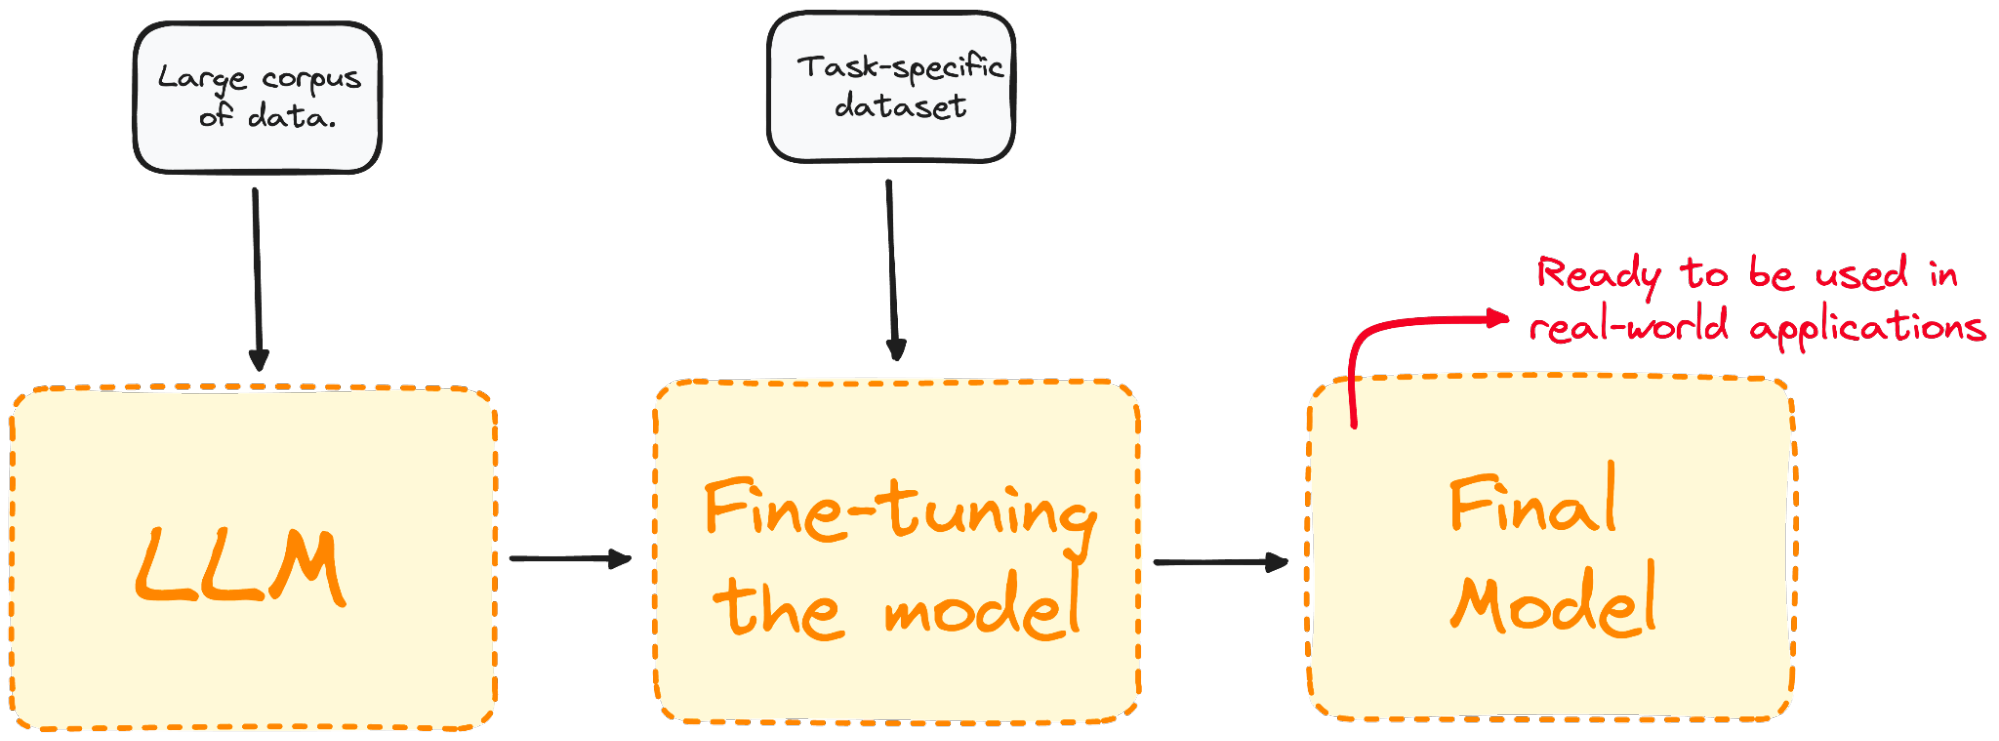

Fine-tuning a pre-trained model like BERT can be approached in various ways depending on the specific task and data availability. Here are the different types of fine-tuning:
1. Full Fine-tuning

    Description: The entire pre-trained model is fine-tuned on the specific task.

    Use Case: Suitable when you have a sufficient amount of labeled data for your specific task, allowing the model to learn task-specific representations.

    Example: Fine-tuning BERT for sentiment analysis on a dataset of movie reviews.

2. Feature-based Fine-tuning

    Description: The pre-trained model is used as a feature extractor. The outputs from certain layers are used as input features for a separate classifier (e.g., logistic regression, SVM).

    Use Case: Useful when you have limited labeled data or want to leverage the pre-trained embeddings without modifying the core model.

    Example: Extracting embeddings from BERT and training a linear classifier for topic classification.

3. Task-specific Fine-tuning

    Description: Only certain layers of the model are fine-tuned while the others remain frozen.

    Use Case: This approach can help prevent overfitting, especially with smaller datasets, by maintaining general representations from the pre-trained model.

    Example: Fine-tuning only the last layer of BERT for named entity recognition.

4. Domain Adaptation

    Description: Fine-tuning the model on a dataset that is similar to but not exactly the same as the target task. This can include transferring from one domain to another.

    Use Case: Helps the model adapt its knowledge to specific language or domain nuances.

    Example: Fine-tuning BERT trained on news articles with a dataset of legal documents.

5. Multi-task Fine-tuning

    Description: Training the model on multiple tasks simultaneously, which can help it learn shared representations and improve performance across tasks.

    Use Case: Effective when tasks are related and can benefit from shared learning.

    Example: Fine-tuning BERT for both sentiment analysis and topic classification at the same time.

6. Adapter Fine-tuning

    Description: Inserting small, trainable layers (adapters) into the pre-trained model and only training these adapters while keeping the original model parameters frozen.

    Use Case: Reduces the number of parameters to train, making fine-tuning more efficient.
    
    Example: Adding adapters for specific tasks like question answering or summarization.

7. Few-shot learning

  There are some cases where collecting a large labeled dataset is impractical. Few-shot learning tries to address this by providing a few examples (or shots) of the required task at the beginning of the input prompts. This helps the model have a better context of the task without an extensive fine-tuning process.

Steps for Fine-Tuning BERT

    Load Pre-trained Model:
        Start with a pre-trained BERT model (e.g., bert-base-uncased), which has already learned general language features.

    Prepare Dataset:
        Gather your dataset and split it into training and validation sets. Ensure that the data is labeled according to the task (e.g., categories for classification).

    Preprocess Data:
        Tokenize the text using the BERT tokenizer, which converts text into input IDs and attention masks. This prepares the text for the model.

    Create DataLoaders:
        Create training and validation DataLoaders to feed batches of data into the model.

    Set Hyperparameters:
        Define hyperparameters such as learning rate, batch size, number of epochs, and maximum sequence length.

    Train the Model:
        Use a suitable loss function (e.g., cross-entropy for classification) and an optimizer (like Adam) to train the model on your dataset. Monitor performance metrics like accuracy and loss.

    Evaluate the Model:
        After training, evaluate the model on the validation set to assess its performance. Use metrics like accuracy, F1 score, etc.

    Fine-tune Hyperparameters:
        Based on the evaluation results, you may need to adjust hyperparameters and retrain to improve performance.

    Save the Model:
        Once satisfied with the results, save the fine-tuned model for future inference.

    Inference:

    Use the fine-tuned model to make predictions on new, unseen data.

Fine-Tuning BERT: Theoretical Overview

    Transfer Learning:
        BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that has learned to understand language from vast amounts of text. Fine-tuning leverages this transfer learning, allowing the model to adapt to specific tasks without starting from scratch.

    Task-Specific Layers:
        During fine-tuning, a task-specific layer (like a classification head) is added on top of the BERT model. This layer is trained to map BERT’s rich contextual embeddings to the output classes relevant to your specific task (e.g., sentiment, topic classification).

        Example: For news classification, you might add a dense layer with softmax activation to classify articles into categories such as "Politics," "Sports," "Technology," etc. This layer maps the features extracted by BERT to these categori

    Input Representation:
        Inputs to BERT consist of token IDs, attention masks, and segment IDs.
        
        Token IDs represent words or subwords, attention masks indicate which tokens should be attended to (i.e., ignore padding), and segment IDs distinguish different segments of text (useful for tasks involving pairs of sentences).

        Example:

        Tokenization: An article like "The government passed a new law." would be tokenized into individual
         tokens, e.g., ["the", "government", "passed", "a", "new", "law", "."].
        Token IDs: These tokens are then converted into numerical IDs that BERT understands.
        Token IDs: [1012, 2005, 2078, 1037, 2197, 1282, 102]
        Attention Masks: For the input, you would create an attention mask indicating which tokens to consider (1) and which are padding (0).
        Attention Mask: [1, 1, 1, 1, 1, 1, 1]
        Segment IDs: If your task involves pairs of sentences (e.g., question-answering), segment IDs would help BERT understand the relationship between them.
        [0, 0, 0, 0, 0, 0, 0]


        Output

        Tokens (with Padding):
            ["The", "government", "passed", "a", "new", "law", ".", "[SEP]", "This", "law", "affects", "all", "citizens", "[PAD]", "[PAD]"]

        Token IDs:
            [1012, 2005, 2078, 1037, 2197, 1282, 102, 102, 2021, 1282, 6164, 2031, 2010, 6290, 0, 0]
            (Here, 0 represents the padding tokens.)

        Attention Mask:
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
            (This indicates that the first 14 tokens are important, while the last two are padding.)

        Segment IDs:
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
            (The first seven tokens belong to Sentence 1 (ID 0), and the next seven belong to Sentence 2 (ID 1). The last two are padding.)

    Training Process:
        Fine-tuning is typically performed with labeled data. The model is trained using gradient descent, adjusting the weights of the pre-trained model based on the loss calculated from the predictions and actual labels.

        Example: You have a dataset of news articles labeled as "Politics" or "Sports." During training, the model sees an article, makes a prediction, and calculates the loss based on the difference between its prediction and the actual label. The model's weights are then adjusted to improve future predictions.

    Hyperparameter Optimization:
        Key hyperparameters (e.g., learning rate, batch size, number of epochs) are crucial for effective fine-tuning. These can significantly affect model performance and should be carefully chosen.

        Example:

        Learning Rate: Starting with a learning rate of 3e-5 might allow the model to learn effectively without overshooting optimal weights.
        Batch Size: Choosing a batch size of 8 means the model updates its weights after processing 8 articles, balancing memory usage and training stability.

    Evaluation and Overfitting:
        The model is evaluated on a validation set to ensure it generalizes well to unseen data. Monitoring metrics like accuracy and loss helps prevent overfitting, where the model performs well on training data but poorly on new data.

        Example: Suppose your validation set contains news articles not seen during training. If the model achieves 90% accuracy on the training set but only 70% on the validation set, it may be overfitting. Monitoring metrics like accuracy, precision, and recall helps identify this.

    Final Model Usage:
        Once fine-tuned, the model can be deployed for inference on new data, utilizing its learned representations to make predictions based on the specific task it was trained for.

In [ ]:
import shutil

In [ ]:
shutil.rmtree('/content/cache_dir')
shutil.rmtree('/content/outputs')
shutil.rmtree('/content/runs')

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging



# Preparing train data
train_data = [
    ["Aragorn was the heir of Isildur", 1],
    ["Frodo was the heir of Isildur", 0],
    ["Pippin is stronger than Merry", 2],
]
train_df = pd.DataFrame(train_data)
train_df.columns = ["text", "labels"]

# Preparing eval data
eval_data = [
    ["Aragorn was the heir of Elendil", 1],
    ["Sam was the heir of Isildur", 0],
    ["Merrry is stronger than Pippin", 2],
]
eval_df = pd.DataFrame(eval_data)
eval_df.columns = ["text", "labels"]

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1)

# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'bert-base-cased',
    num_labels=3,
    args=model_args
)

# Train the model
model.train_model(train_df)


from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')




# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df,f1=f1_multiclass, acc=accuracy_score)

# Make predictions with the model
predictions, raw_outputs = model.predict(["Sam was a Wizard"])

Finetuning BERT for text classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from simpletransformers.classification import ClassificationModel

# Load the dataset
data = pd.read_csv('BBC News Train.csv')  # Adjust the path as needed

# Assuming the dataset has columns 'Text' and 'Category'
texts = data['Text'].values
labels = data['Category'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create DataFrames for SimpleTransformers
train_df = pd.DataFrame({'text': X_train, 'labels': y_train_encoded})
test_df = pd.DataFrame({'text': X_test, 'labels': y_test_encoded})

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=len(label_encoder.classes_))

# Train the model
model.train_model(train_df)


from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')



# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df,f1=f1_multiclass, acc=accuracy_score)
print(result)


Finetuning BERT for text classification hyperparameter

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import f1_score, accuracy_score

# Load the dataset
data = pd.read_csv('BBC News Train.csv')  # Adjust the path as needed

# Assuming the dataset has columns 'Text' and 'Category'
texts = data['Text'].values
labels = data['Category'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create DataFrames for SimpleTransformers
train_df = pd.DataFrame({'text': X_train, 'labels': y_train_encoded})
test_df = pd.DataFrame({'text': X_test, 'labels': y_test_encoded})



# Set up model arguments
model_args = ClassificationArgs(
    num_train_epochs=3,       # Start with 3 epochs
    train_batch_size=8,       # Use a batch size of 8
    eval_batch_size=8,        # Same for evaluation
    learning_rate=3e-5,       # Learning rate
    max_seq_length=128,       # Max sequence length
    weight_decay=0.01,        # Weight decay
    warmup_steps=0,           # Optional: adjust based on total steps
    logging_steps=50,         # Log training progress every 50 steps
    save_steps=200,           # Save the model every 200 steps
)

# Create a ClassificationModel with hyperparameters
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=len(label_encoder.classes_), args=model_args)

# Train the model
model.train_model(train_df)

# Custom evaluation function
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)
print(result)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/149 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/149 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': 0.9705960922283702, 'f1': 0.9765100671140939, 'acc': 0.9765100671140939, 'eval_loss': 0.09756179859763697}


Increasing the epochs

ref : https://www.analyticsvidhya.com/blog/2021/12/text-classification-of-news-articles/
https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35

https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/

https://turbolab.in/feature-extraction-in-natural-language-processing-nlp/
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
https://eshban9492.medium.com/feature-engineering-in-nlp-7d89bf47f7ae\

https://github.com/mohdahmad242/Feature-Engineering-in-NLP/blob/main/Feature_engineering_NLP.ipynb

https://towardsdatascience.com/multiclass-text-classification-using-keras-to-predict-emotions-a-comparison-with-and-without-word-5ef0a5eaa1a0

https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d

https://stats.stackexchange.com/questions/365428/difference-between-a-single-unit-lstm-and-3-unit-lstm-neural-network

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://github.com/mmalam3/BBC-News-Classification-using-LSTM-and-TensorFlow/blob/main/bbc_news_classification.ipynb

https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network

https://www.kaggle.com/code/mohamedbakrey/make-a-classification-for-bbc-news-by-lstm

https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network

https://knowledge.dataiku.com/latest/ml-analytics/nlp/concept-text-features-for-ml.html

https://www.turing.com/resources/finetuning-large-language-models

https://www.datacamp.com/tutorial/fine-tuning-large-language-models

https://klu.ai/glossary/large-language-model

https://www.altexsoft.com/blog/language-models-gpt/

https://jalammar.github.io/